
    
<Image_UNIR><center>
![UNIR](https://www.turnitin.com/img/http/aHR0cHM6Ly9tYXJrZXRpbmctdGlpLXN0YXRhbWljLWFzc2V0cy11cy13ZXN0LTIuczMtdXMtd2VzdC0yLmFtYXpvbmF3cy5jb20vbG9nb3MvcmlvamFsb2dvLmpwZw==?w=400&s=dfd09f2b0e80bdb671e01d577686dbd1)</center>

# <center>Proyecto Final de Grado </center>

***<center> Análisis y predicción de la percepción de los ciudadanos del funcionamiento del sistema sanitario </center>***
<br>

___

<br>
<div style="margin-left: auto;
            margin-right: auto;
            width: 50%">

|              Autor              |
|:-------------------------------:|
|              Amaya Jiménez Oteiza              |    
</div>

<br>


## <center> Introducción

## <center> Desarrollo

### <center> Fase de comprensión de los datos

#### <center> Extractor de Datos

Módulo para realizar la extracción de datos de un archivo de entrada.

Este módulo contiene la clase Extractor, la cual se encarga de ejecutar la extracción de
datos de un archivo de entrada y escribir el resultado en un archivo de salida.

La configuración de entrada y salida se especifica en un archivo JSON.

In [1]:
import ast, warnings
from typing import List

import pandas as pd
import pyspark
import pyspark.sql.functions as pyspark_functions
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StringType, StructType, IntegerType

warnings.filterwarnings("ignore")

In [2]:
# Ruta del archivo de configuración
CONFIG_PATH = "resources/config/extraction_config.json"

# Clave para acceder a la configuración común en el archivo de configuración
COMMON = "common"

# Claves para acceder a la configuración de entrada en el archivo de configuración
FILE_PATH = "file_path"
COLUMN_NAMES = "column_names"
COLUMN_WIDTH = "column_width"
COLUMN_INTERSECTION = "column_intersection"
SEP_INPUT = "sep_input"

# Clave para acceder a la configuración de salida en el archivo de configuración
SEP_OUTPUT = "sep_output"

# Clave para acceder a la configuración de entrada - Pandas en el archivo de configuración
PANDAS = "pandas"
PANDAS_OUTPUT_PATH = "pandas_output_path"

# Clave para acceder a la configuración de entrada - PySpark en el archivo de configuración
PYSPARK = "pyspark"
PYSPARK_MASTER = "pyspark_master"
PYSPARK_APPLICATION_NAME = "pyspark_application_name"
PYSPARK_OUTPUT_PATH = "pyspark_output_path"

# Separador de salida
OUTPUT_SEP = ";"

In [3]:
class Extractor:
    """
    Clase para realizar la extracción de datos de un archivo de entrada.

    Atributos:
        * output_column_names (list): Nombres de las columnas de salida.
        * date (str): Fecha de los datos a extraer.
        * file_path (str): Ruta del archivo de entrada.
        * input_column_names (list): Nombres de las columnas de entrada.
        * input_column_intersection (list): Nombres de las columnas de entrada a conservar.
        * column_width (list): Ancho de cada columna de entrada.
        * sep_input (str): Separador de las columnas de entrada.
        * pandas_output_path (str): Ruta del archivo de salida para el método de extracción de Pandas.
        * pyspark_master (str): Dirección del maestro de PySpark.
        * pyspark_application_name (str): Nombre de la aplicación de PySpark.
        * pyspark_output_path (str): Ruta del archivo de salida para el método de extracción de PySpark.
        * mapper (dict): Diccionario para renombrar las columnas de entrada a las de salida.
        * input_reduced_column_names (list): Nombres de las columnas de entrada a conservar.
    """

    def __init__(self, date: str, input_config_dict: dict, output_config_dict: dict):
        """
        Inicializa una instancia de la clase Extractor.

        :param date: Fecha de los datos a extraer.
        :param input_config_dict: Diccionario con la configuración de entrada.
        :param output_config_dict: Diccionario con la configuración de salida.
        """
        print(f"Data Extractor - {date}")
        # Configuración común
        self.output_column_names: list = output_config_dict.get("column_names")
        self.date = date
        common_config = input_config_dict.get(COMMON)
        self.file_path = common_config.get(FILE_PATH)
        self.input_column_names = common_config.get(COLUMN_NAMES)
        self.input_column_intersection = common_config.get(COLUMN_INTERSECTION)
        column_width_str = common_config.get(COLUMN_WIDTH)
        self.column_width = list(ast.literal_eval(column_width_str))
        self.sep_input = common_config.get(SEP_INPUT)
        # Configuración de entrada - Pandas
        pandas_config = input_config_dict.get(PANDAS)
        self.pandas_output_path = pandas_config.get(PANDAS_OUTPUT_PATH)
        # Configuración de entrada - PySpark
        pyspark_config = input_config_dict.get(PYSPARK)
        self.pyspark_master = pyspark_config.get(PYSPARK_MASTER)
        self.pyspark_application_name = pyspark_config.get(PYSPARK_APPLICATION_NAME)
        self.pyspark_output_path = pyspark_config.get(PYSPARK_OUTPUT_PATH)
        # Crea un diccionario para renombrar las columnas de entrada a las de salida
        self.mapper: dict = {columns_zip[0]: columns_zip[1] for columns_zip in
                             zip(self.input_column_intersection, self.output_column_names)}
        self.input_reduced_column_names = list(self.mapper.keys())

    def pandas_extractor(self):
        """
        Realiza la extracción de datos utilizando Pandas.

        Escribe el resultado en un archivo de salida en la ruta especificada en pandas_output_path.
        """
        # Realiza la extracción de datos utilizando Pandas
        df_data = pd.read_fwf(self.file_path, colspecs=self.column_width, header=None)
        df_data.columns = self.input_column_names
        df_data = df_data[self.input_reduced_column_names]
        df_data = df_data.rename(mapper=self.mapper, axis=1)
        df_data["FECHA"] = self.date
        # Escribe el resultado en un archivo de salida
        df_data.to_csv(self.pandas_output_path, sep=OUTPUT_SEP, index=False)
        print(f"{self.date}_PANDAS_EXTRACTED")
        return df_data

    def pyspark_extractor(self):
        """
        Realiza la extracción de datos utilizando PySpark.

        Escribe el resultado en un archivo de salida en la ruta especificada en pyspark_output_path.
        """
        # Inicializa una sesión de Spark
        spark = SparkSession.builder.master(self.pyspark_master).appName(
            self.pyspark_application_name).getOrCreate()
        # Realiza la extracción de datos utilizando PySpark
        df_data = spark.read.text(self.file_path)
        select_expr_columns = [
            df_data.value.substr(w[0] + 1, w[1] - w[0]).alias(n) if w[0] != 0
            else df_data.value.substr(w[0], w[1] - w[0]).alias(n)
            for w, n in zip(self.column_width, self.input_column_names)
        ]
        df_data = df_data.select(select_expr_columns)
        df_data = df_data.select([pyspark.sql.functions.col(c).alias(self.mapper.get(c, c)) for c in df_data.columns])
        df_data = df_data.select(self.output_column_names)
        df_data = df_data.withColumn("FECHA", pyspark.sql.functions.lit(self.date))
        # Escribe el resultado en un archivo de salida
        df_data.repartition(1).write.csv(path=self.pyspark_output_path, header=True, sep=self.sep_input,
                                         mode="overwrite")
        print(f"{self.date}_PYSPARK_EXTRACTED")
        return df_data

    @staticmethod
    def json_extractor(json_file_path: str = CONFIG_PATH):
        """
        Realiza la extracción de datos de un archivo JSON.

        Args:
            json_file_path: La ruta del archivo JSON del cual se extraerán los datos.

        Returns:
            Un diccionario con los datos del archivo JSON.

        Raises:
            Exception: Sí ocurre un error al leer el archivo JSON.
        """
        import json
        try:
            with open(json_file_path) as f:
                data = json.load(f)
            print(f"Data extraction complete from JSON file {json_file_path}")
            return data
        except Exception as e:
            raise Exception(f"Error in {Extractor.json_extractor.__name__} function: {e}")

In [4]:
class Concatenator:
    """
    Clase utilizada para concatenar múltiples dataframes de pandas o PySpark en uno solo.

    Atributos:
    - sep_output (str): Separador usado para el archivo de salida.
    - output_path (str): Ruta del archivo de salida.
    - pyspark_master (str): Nombre del maestro de PySpark.
    - pyspark_application_name (str): Nombre de la aplicación de PySpark.

    Métodos:
    - pandas_concat: Concatena múltiples dataframes de pandas en uno solo y lo guarda en un archivo CSV.
    - pyspark_concat: Concatena múltiples dataframes de PySpark en uno solo y lo guarda en un archivo CSV.

    Args:
    - output_config (dict): Diccionario que contiene información de configuración sobre el archivo de salida.
    - concatenator_type (str): Cadena que especifica el tipo de concatenador que se está utilizando.
    """

    def __init__(self, output_config: dict, concatenator_type: str):
        self.sep_output: str = output_config.get(SEP_OUTPUT)
        self.output_path: str = output_config.get("output_path")
        self.pyspark_master = output_config.get("pyspark").get("pyspark_master")
        self.pyspark_application_name = output_config.get("pyspark").get("pyspark_application_name")

    def pandas_concat(self, dfs: List[pd.DataFrame], output_name="PANDAS_BAROMETRO.csv"):
        """
        Concatena múltiples dataframes de pandas en uno solo y lo guarda en un archivo CSV.

        Args:
        - dfs (List[pd.DataFrame]): Lista de dataframes de pandas a concatenar.

        Returns:
        pd.DataFrame: Dataframe resultante de la concatenación.
        """
        df_pandas_concatenated = pd.concat(dfs, axis=0, ignore_index=True)
        df_pandas_concatenated.to_csv(self.output_path.format(output_name), header=True, index=False,
                                      sep=self.sep_output,
                                      mode="w")
        return df_pandas_concatenated

    def pyspark_concat(self, dfs: List[pyspark.sql.DataFrame], schema):
        """
        Concatena múltiples dataframes de PySpark en uno solo y lo guarda en un archivo CSV.

        Args:
        - dfs (List[pyspark.sql.DataFrame]): Lista de dataframes de PySpark a concatenar.
        - schema (pyspark.sql.types.StructType): Esquema para el dataframe resultante.

        Returns:
        pyspark.sql.DataFrame: Dataframe resultante de la concatenación.
        """
        spark = SparkSession.builder.master(self.pyspark_master).appName(self.pyspark_application_name).getOrCreate()
        df_pyspark_concatenated = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
        for df in dfs:
            df_pyspark_concatenated = df_pyspark_concatenated.union(df)
        try:
            df_pyspark_concatenated.repartition(1).write. \
                csv(path=self.output_path.format("PYSPARK_BAROMETRO.csv"), header=True, sep=self.sep_output,
                    mode="overwrite")
        except Exception as e:
            print(e)
        return df_pyspark_concatenated

In [5]:
# Carga la configuración de entrada y salida de la extracción de datos
data_extractor_config = Extractor.json_extractor().get("data").get("extractor")
input_config = data_extractor_config.get("input")
output_config = data_extractor_config.get("output")

# Realiza la extracción de datos con Pandas para cada fecha en la configuración de entrada
df_pandas_by_date = [
        Extractor(date=date, input_config_dict=config, output_config_dict=output_config).pandas_extractor()
        for date, config in input_config.items()
    ]

# Concatena los dataframes obtenidos con Pandas
df_pandas_concatenated = Concatenator(
        output_config=output_config,
        concatenator_type="pandas"
    ).pandas_concat(df_pandas_by_date)

Data extraction complete from JSON file resources/config/extraction_config.json
Data Extractor - 2015
2015_PANDAS_EXTRACTED
Data Extractor - 2016
2016_PANDAS_EXTRACTED
Data Extractor - 2017
2017_PANDAS_EXTRACTED
Data Extractor - 2018
2018_PANDAS_EXTRACTED
Data Extractor - 2019
2019_PANDAS_EXTRACTED
Data Extractor - 2022_1
2022_1_PANDAS_EXTRACTED
Data Extractor - 2022_2
2022_2_PANDAS_EXTRACTED


In [6]:
# Realiza la extracción de datos con PySpark para cada fecha en la configuración de entrada
df_pyspark_by_date = [
        Extractor(date=date, input_config_dict=config, output_config_dict=output_config).pyspark_extractor()
        for date, config in input_config.items()
    ]

# Concatena los dataframes obtenidos con PySpark
schema = StructType([StructField('ESTU', IntegerType(), True),
                         StructField('CUES', IntegerType(), True),
                         StructField('CCAA', IntegerType(), True),
                         StructField('PROV', IntegerType(), True),
                         StructField('MUN', IntegerType(), True),
                         StructField('TAMUNI', IntegerType(), True),
                         StructField('ENTREV', IntegerType(), True),
                         StructField('OLA', IntegerType(), True),
                         StructField('OPISS', IntegerType(), True),
                         StructField('ESCSATI', IntegerType(), True),
                         StructField('ELEATPR', IntegerType(), True),
                         StructField('ELEATESPE', IntegerType(), True),
                         StructField('ELEINGHOSP', IntegerType(), True),
                         StructField('ELEURG', IntegerType(), True),
                         StructField('ESCAATPR', IntegerType(), True),
                         StructField('ELEASESP', IntegerType(), True),
                         StructField('ESCAURG', IntegerType(), True),
                         StructField('ESCAINGHOSP', IntegerType(), True),
                         StructField('ASISMEDCAB', IntegerType(), True),
                         StructField('VALMEDCAB', IntegerType(), True),
                         StructField('TRATPERSAN', IntegerType(), True),
                         StructField('TIEMDEDMECCAB', IntegerType(), True),
                         StructField('CONFMEDCAB', IntegerType(), True),
                         StructField('CONOHISSEG', IntegerType(), True),
                         StructField('INFPROBSALUD', IntegerType(), True),
                         StructField('ASISSERVURG', IntegerType(), True),
                         StructField('TIPOSERVURG', IntegerType(), True),
                         StructField('VALSERVURG', IntegerType(), True),
                         StructField('ASISATESP', IntegerType(), True),
                         StructField('VALATESP', IntegerType(), True),
                         StructField('TIEMMEDATESP', IntegerType(), True),
                         StructField('COFMEDATESP', IntegerType(), True),
                         StructField('INFPROBATESP', IntegerType(), True),
                         StructField('ASITINGHOSP', IntegerType(), True),
                         StructField('VALATHOSPUB', IntegerType(), True),
                         StructField('VALATMEDHOSP', IntegerType(), True),
                         StructField('VALATENFHOSP', IntegerType(), True),
                         StructField('VALNUMPERSCOMPHAB', IntegerType(), True),
                         StructField('VALEQTECHOSP', IntegerType(), True),
                         StructField('VALINFPROSALHOSP', IntegerType(), True),
                         StructField('VALLISTESP', IntegerType(), True),
                         StructField('IMPTOMTRAT', IntegerType(), True),
                         StructField('UBICIDEOL', IntegerType(), True),
                         StructField('PARTULTELEC', IntegerType(), True),
                         StructField('RECUVOTO', IntegerType(), True),
                         StructField('SEXO', IntegerType(), True),
                         StructField('EDAD', IntegerType(), True),
                         StructField('ECIVIL', IntegerType(), True),
                         StructField('ESCUELA', IntegerType(), True),
                         StructField('NIVELESTENTREV', IntegerType(), True),
                         StructField('ESTSALUD', IntegerType(), True),
                         StructField('ENFCRONICA', IntegerType(), True),
                         StructField('SITLAB', IntegerType(), True),
                         StructField('OCUPACION', IntegerType(), True),
                         StructField('NACIONALIDAD', IntegerType(), True),
                         StructField('ADQUINAC', IntegerType(), True),
                         StructField('NACEXTR', IntegerType(), True),
                         StructField('NIVCASTE', IntegerType(), True),
                         StructField('PAISNAC', IntegerType(), True),
                         StructField('PAISNACEXTR', IntegerType(), True),
                         StructField('FECHA', StringType(), False)])

df_pyspark_concatenated = Concatenator(output_config=output_config, concatenator_type="pyspark").pyspark_concat(df_pyspark_by_date, schema=schema)

Data Extractor - 2015
2015_PYSPARK_EXTRACTED
Data Extractor - 2016
2016_PYSPARK_EXTRACTED
Data Extractor - 2017
2017_PYSPARK_EXTRACTED
Data Extractor - 2018
2018_PYSPARK_EXTRACTED
Data Extractor - 2019
2019_PYSPARK_EXTRACTED
Data Extractor - 2022_1
2022_1_PYSPARK_EXTRACTED
Data Extractor - 2022_2
2022_2_PYSPARK_EXTRACTED


#### <center> Comparador de Datos

Este código compara el rendimiento de pandas y pyspark al leer y procesar un archivo CSV.

A continuación se ofrece una breve descripción de lo que hace el código:

* Importa los módulos necesarios:
    * datetime para medir el tiempo de ejecución de cada proceso
    * pandas para utilizar sus capacidades de procesamiento de datos
    * pyplot de matplotlib para crear un gráfico de barras con los resultados
    * SparkSession de pyspark.sql para crear una sesión de spark
* Mide el tiempo de ejecución de la lectura y el procesamiento del archivo CSV con pandas:
    * Inicializa el tiempo de inicio con datetime.now()
    * Lee el archivo CSV utilizando pd.read_csv() y lo almacena en un DataFrame de pandas llamado df_pandas
    * Inicializa el tiempo final con datetime.now()
    * Calcula el tiempo de ejecución restando el tiempo de inicio del tiempo final y lo almacena en execution_time_pandas
* Mide el tiempo de ejecución de la lectura y el procesamiento del archivo CSV con pyspark:
    * Inicializa el tiempo de inicio con datetime.now()
    * Crea una sesión de spark con SparkSession.builder.master("local[*]").appName("tfg_amaya_comparator").getOrCreate()
    * Lee el archivo CSV utilizando spark.read.text() y lo almacena en un DataFrame de pyspark llamado df_data_health_barometer_pyspark
    * Inicializa el tiempo final con datetime.now()
    * Calcula el tiempo de ejecución restando el tiempo de inicio del tiempo final y lo almacena en execution_time_pyspark
* Crea un DataFrame de pandas llamado df_execution_time que contiene los resultados de la comparación
* Representa los resultados en un gráfico de barras utilizando matplotlib

In [7]:
from datetime import datetime

import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession

In [8]:
INPUT_PATH_PANDAS = "resources/data/extractor/output/concatenated/PANDAS_BAROMETRO.csv"
INPUT_PATH_PYSPARK = "resources/data/extractor/output/concatenated/PYSPARK_BAROMETRO.csv"

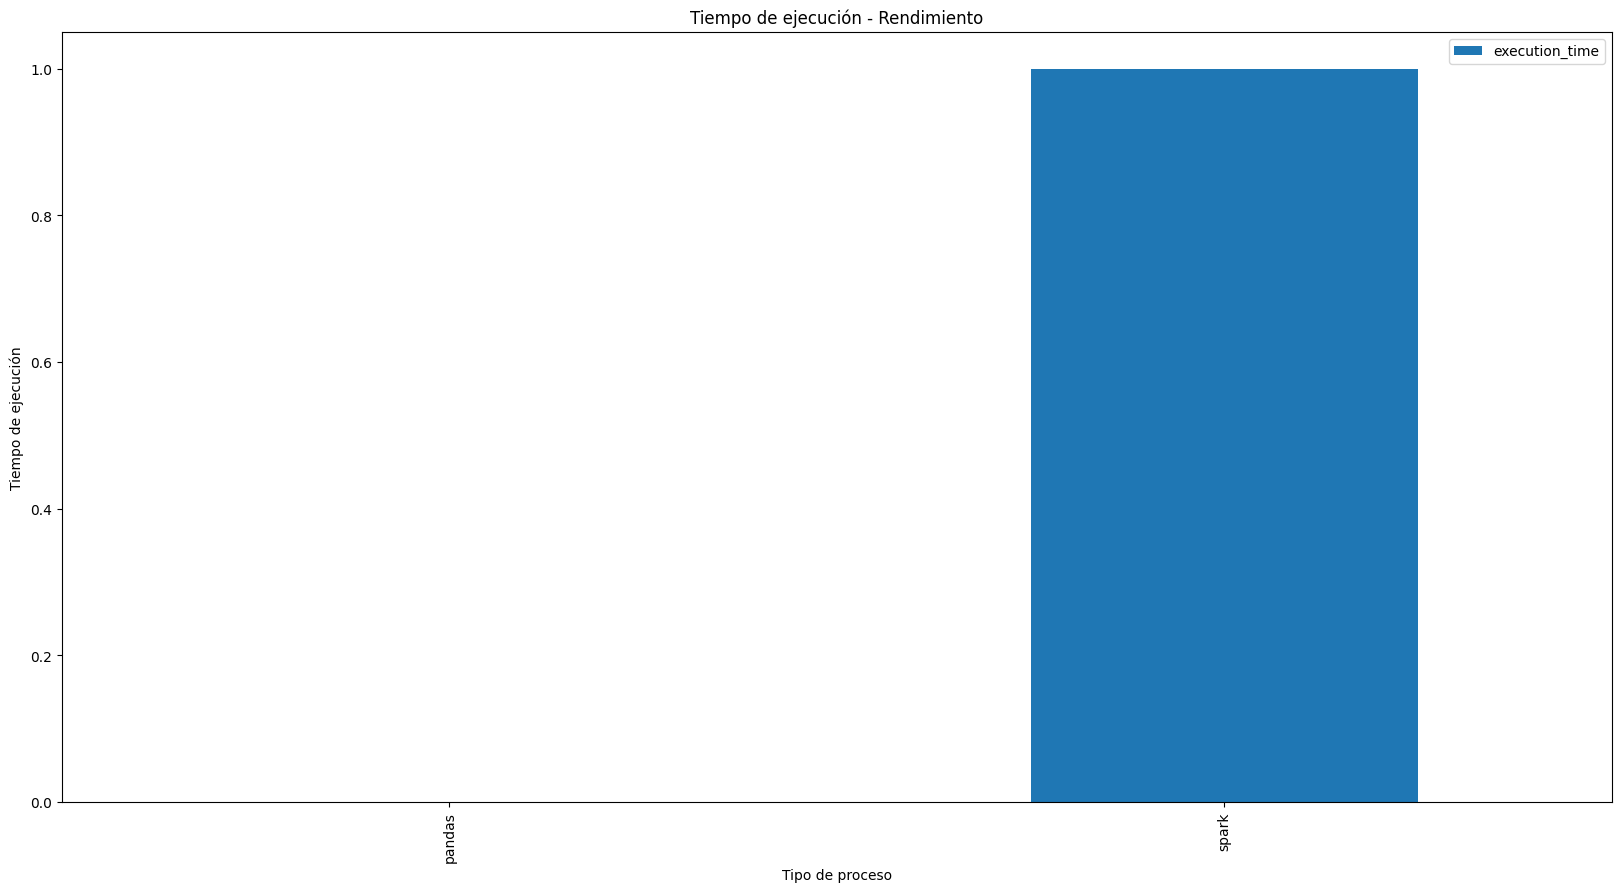

In [9]:
# pandas
start_time = datetime.now()  # inicializamos el tiempo de inicio
# leemos el archivo CSV con pandas y lo almacenamos en un DataFrame
df_pandas = pd.read_csv(INPUT_PATH_PANDAS, sep=";")
end_time = datetime.now()  # inicializamos el tiempo final
# calculamos el tiempo de ejecución restando el tiempo final del tiempo de inicio y lo convertimos a segundos
execution_time_pandas = (end_time - start_time).seconds

# pyspark
# inicializamos el tiempo de inicio
start_time = datetime.now()

# creamos una sesión de spark
spark = SparkSession.builder.master("local[*]").appName("tfg_comparator").getOrCreate()

# leemos el archivo CSV con pyspark y lo almacenamos en un DataFrame
df_data_health_barometer_pyspark = spark.read.csv(INPUT_PATH_PYSPARK, sep=";", header=True, inferSchema=True)

end_time = datetime.now()  # inicializamos el tiempo final
# calculamos el tiempo de ejecución restando el tiempo final del tiempo de inicio y lo convertimos a segundos
execution_time_pyspark = (end_time - start_time).seconds

# creamos un DataFrame de pandas con los resultados de la comparación
data = [['pandas', execution_time_pandas], ['spark', execution_time_pyspark]]
df_execution_time = pd.DataFrame(data=data, columns=["process_type", "execution_time"])

# representamos los resultados en un gráfico de barras
ax = df_execution_time.plot(
    x="process_type",
    y="execution_time",
    title="Tiempo de ejecución - Rendimiento",
    kind="bar",
    legend=True,
    xlabel="Tipo de proceso",
    ylabel="Tiempo de ejecución",
    figsize=(20,10)
)
_ = ax

#### <center> Descripción de los Datos

##### <center> Resultado del módulo 'Extractor de Datos'

In [10]:
INPUT_PATH_PANDAS = "resources/data/extractor/output/concatenated/PANDAS_BAROMETRO.csv"
OUTPUT_SEP = ";"
df_extractor_concatenated = pd.read_csv(INPUT_PATH_PANDAS, sep=OUTPUT_SEP)

##### <center> Numero de Instancias y Atributos

In [11]:
df_extractor_concatenated.shape

(43527, 61)

##### <center> Consulta de las 10 primeras instancias

In [12]:
df_extractor_concatenated.head(10)

,ESTU,CUES,CCAA,PROV,MUN,TAMUNI,ENTREV,OLA,OPISS,ESCSATI,...,ENFCRONICA,SITLAB,OCUPACION,NACIONALIDAD,ADQUINAC,NACEXTR,NIVCASTE,PAISNAC,PAISNACEXTR,FECHA
0,3058,1,16,1,59,5,0.0,1,2,5,...,2,1,611,1,1.0,0.0,0.0,1,0.0,2015
1,3058,2,16,1,59,5,0.0,1,2,1,...,1,7,820,1,1.0,0.0,0.0,1,0.0,2015
2,3058,3,16,1,59,5,0.0,1,1,8,...,2,1,611,1,1.0,0.0,0.0,1,0.0,2015
3,3058,4,16,1,59,5,0.0,1,1,10,...,2,2,530,1,1.0,0.0,0.0,1,0.0,2015
4,3058,5,16,1,59,5,0.0,1,2,4,...,2,1,611,1,1.0,0.0,0.0,1,0.0,2015
5,3058,6,16,1,59,5,0.0,1,1,3,...,2,1,611,1,1.0,0.0,0.0,1,0.0,2015
6,3058,7,16,1,59,5,0.0,1,3,5,...,2,1,611,1,1.0,0.0,0.0,1,0.0,2015
7,3058,8,16,1,59,5,0.0,1,1,7,...,2,6,592,1,1.0,0.0,0.0,1,0.0,2015
8,3058,9,16,1,59,5,0.0,1,1,8,...,2,1,611,1,1.0,0.0,0.0,1,0.0,2015
9,3058,10,16,1,0,1,0.0,1,2,7,...,2,1,213,1,1.0,0.0,0.0,1,0.0,2015


##### <center> Información Básica

In [13]:
df_extractor_concatenated.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43527 entries, 0 to 43526
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ESTU               43527 non-null  int64  
 1   CUES               43527 non-null  int64  
 2   CCAA               43527 non-null  int64  
 3   PROV               43527 non-null  int64  
 4   MUN                43527 non-null  int64  
 5   TAMUNI             43527 non-null  int64  
 6   ENTREV             43526 non-null  float64
 7   OLA                43527 non-null  int64  
 8   OPISS              43527 non-null  int64  
 9   ESCSATI            43527 non-null  int64  
 10  ELEATPR            43527 non-null  int64  
 11  ELEATESPE          43527 non-null  int64  
 12  ELEINGHOSP         43527 non-null  int64  
 13  ELEURG             43527 non-null  int64  
 14  ESCAATPR           43527 non-null  int64  
 15  ELEASESP           43527 non-null  int64  
 16  ESCAURG            435

#### <center> Exploración de los datos

##### <center> Resumen estadístico

In [14]:
df_extractor_concatenated.describe().style.background_gradient(cmap='coolwarm')

,ESTU,CUES,CCAA,PROV,MUN,TAMUNI,ENTREV,OLA,OPISS,ESCSATI,ELEATPR,ELEATESPE,ELEINGHOSP,ELEURG,ESCAATPR,ELEASESP,ESCAURG,ESCAINGHOSP,ASISMEDCAB,VALMEDCAB,TRATPERSAN,TIEMDEDMECCAB,CONFMEDCAB,CONOHISSEG,INFPROBSALUD,ASISSERVURG,TIPOSERVURG,VALSERVURG,ASISATESP,VALATESP,TIEMMEDATESP,COFMEDATESP,INFPROBATESP,ASITINGHOSP,VALATHOSPUB,VALATMEDHOSP,VALATENFHOSP,VALNUMPERSCOMPHAB,VALEQTECHOSP,VALINFPROSALHOSP,VALLISTESP,IMPTOMTRAT,UBICIDEOL,PARTULTELEC,RECUVOTO,SEXO,EDAD,ECIVIL,ESCUELA,NIVELESTENTREV,ESTSALUD,ENFCRONICA,SITLAB,OCUPACION,NACIONALIDAD,ADQUINAC,NACEXTR,NIVCASTE,PAISNAC,PAISNACEXTR
count,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43526.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,38155.000000,38155.000000,38155.000000,38155.000000,38155.000000,38155.000000,43527.000000,32225.000000,32177.000000,43527.000000,33310.000000,33310.000000,33310.000000,33310.000000,43527.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,43527.000000,43527.000000,43527.000000,43526.000000,39729.000000,43527.000000,43527.000000,43527.000000,43527.000000,43047.000000,43527.000000,43527.000000,43527.000000,43527.000000,43527.000000,42630.000000,29601.000000,29754.000000,43527.000000,29871.000000
mean,3197.577090,1286.106509,9.248765,27.081122,32.674156,3.790176,0.000000,383.633446,2.209548,7.301973,1.402601,1.562616,1.433938,1.453764,8.802582,12.141659,11.253774,15.410228,1.372872,1.451684,9.480985,8.894457,9.123260,11.218163,9.503289,1.845981,0.797331,0.734407,1.683989,0.995557,11.928850,11.905134,12.372681,2.119328,0.214646,12.066139,12.123040,10.985272,14.090515,15.281229,3.446711,1.924621,30.812484,1.986031,22.149739,1.514600,49.533163,1.742528,2.965654,6.997584,2.112137,1.691249,2.489627,506.466285,1.149953,1.041919,37.300159,0.725818,1.118639,41.718356
std,82.295692,743.835281,5.202123,14.994372,65.249019,1.608765,0.000000,1066.379853,0.997697,8.176519,0.769795,0.841600,0.873149,0.881750,12.066773,21.652764,21.264118,26.524085,0.688559,1.072485,13.612963,13.538498,12.333359,18.696709,14.174824,0.777939,3.364658,1.160887,0.799219,1.284120,22.260908,21.337019,22.267219,0.717864,0.670048,22.617328,22.585215,23.083726,25.588318,27.782329,2.241159,0.656610,41.991091,2.036990,38.341520,0.499793,17.815684,1.108562,0.265997,6.530163,0.799871,0.587078,1.952928,300.332080,0.500247,0.598035,107.162452,1.840580,0.426335,106.103390
min,3058.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,18.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3140.000000,642.000000,5.000000,13.000000,0.000000,3.000000,0.000000,1.000000,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.000000,5.000000,6.000000,1.000000,1.000000,7.000000,6.000000,7.000000,6.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,5.000000,6.000000,6.000000,2.000000,0.000000,5.000000,5.000000,3.000000,6.000000,5.000000,2.000000,2.000000,4.000000,1.000000,1.000000,1.000000,35.000000,1.000000,3.000000,4.000000,2.000000,1.000000,1.000000,261.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,3192.000000,1284.000000,9.000000,28.000000,0.000000,4.000000,0.000000,2.000000,2.000000,7.000000,1.000000,1.000000,1.000000,1.000000,8.000000,7.000000,6.000000,7.000000,1.000000,2.000000,8.000000,7.000000,8.000000,8.000000,8.000000,2.000000,0.000000,0.000000,2.000000,0.000000,7.000000,8.000000,8.000000,2.000000,0.000000,7.000000,8.000000,6.000000,8.000000,7.000000

##### <center> Histogramas

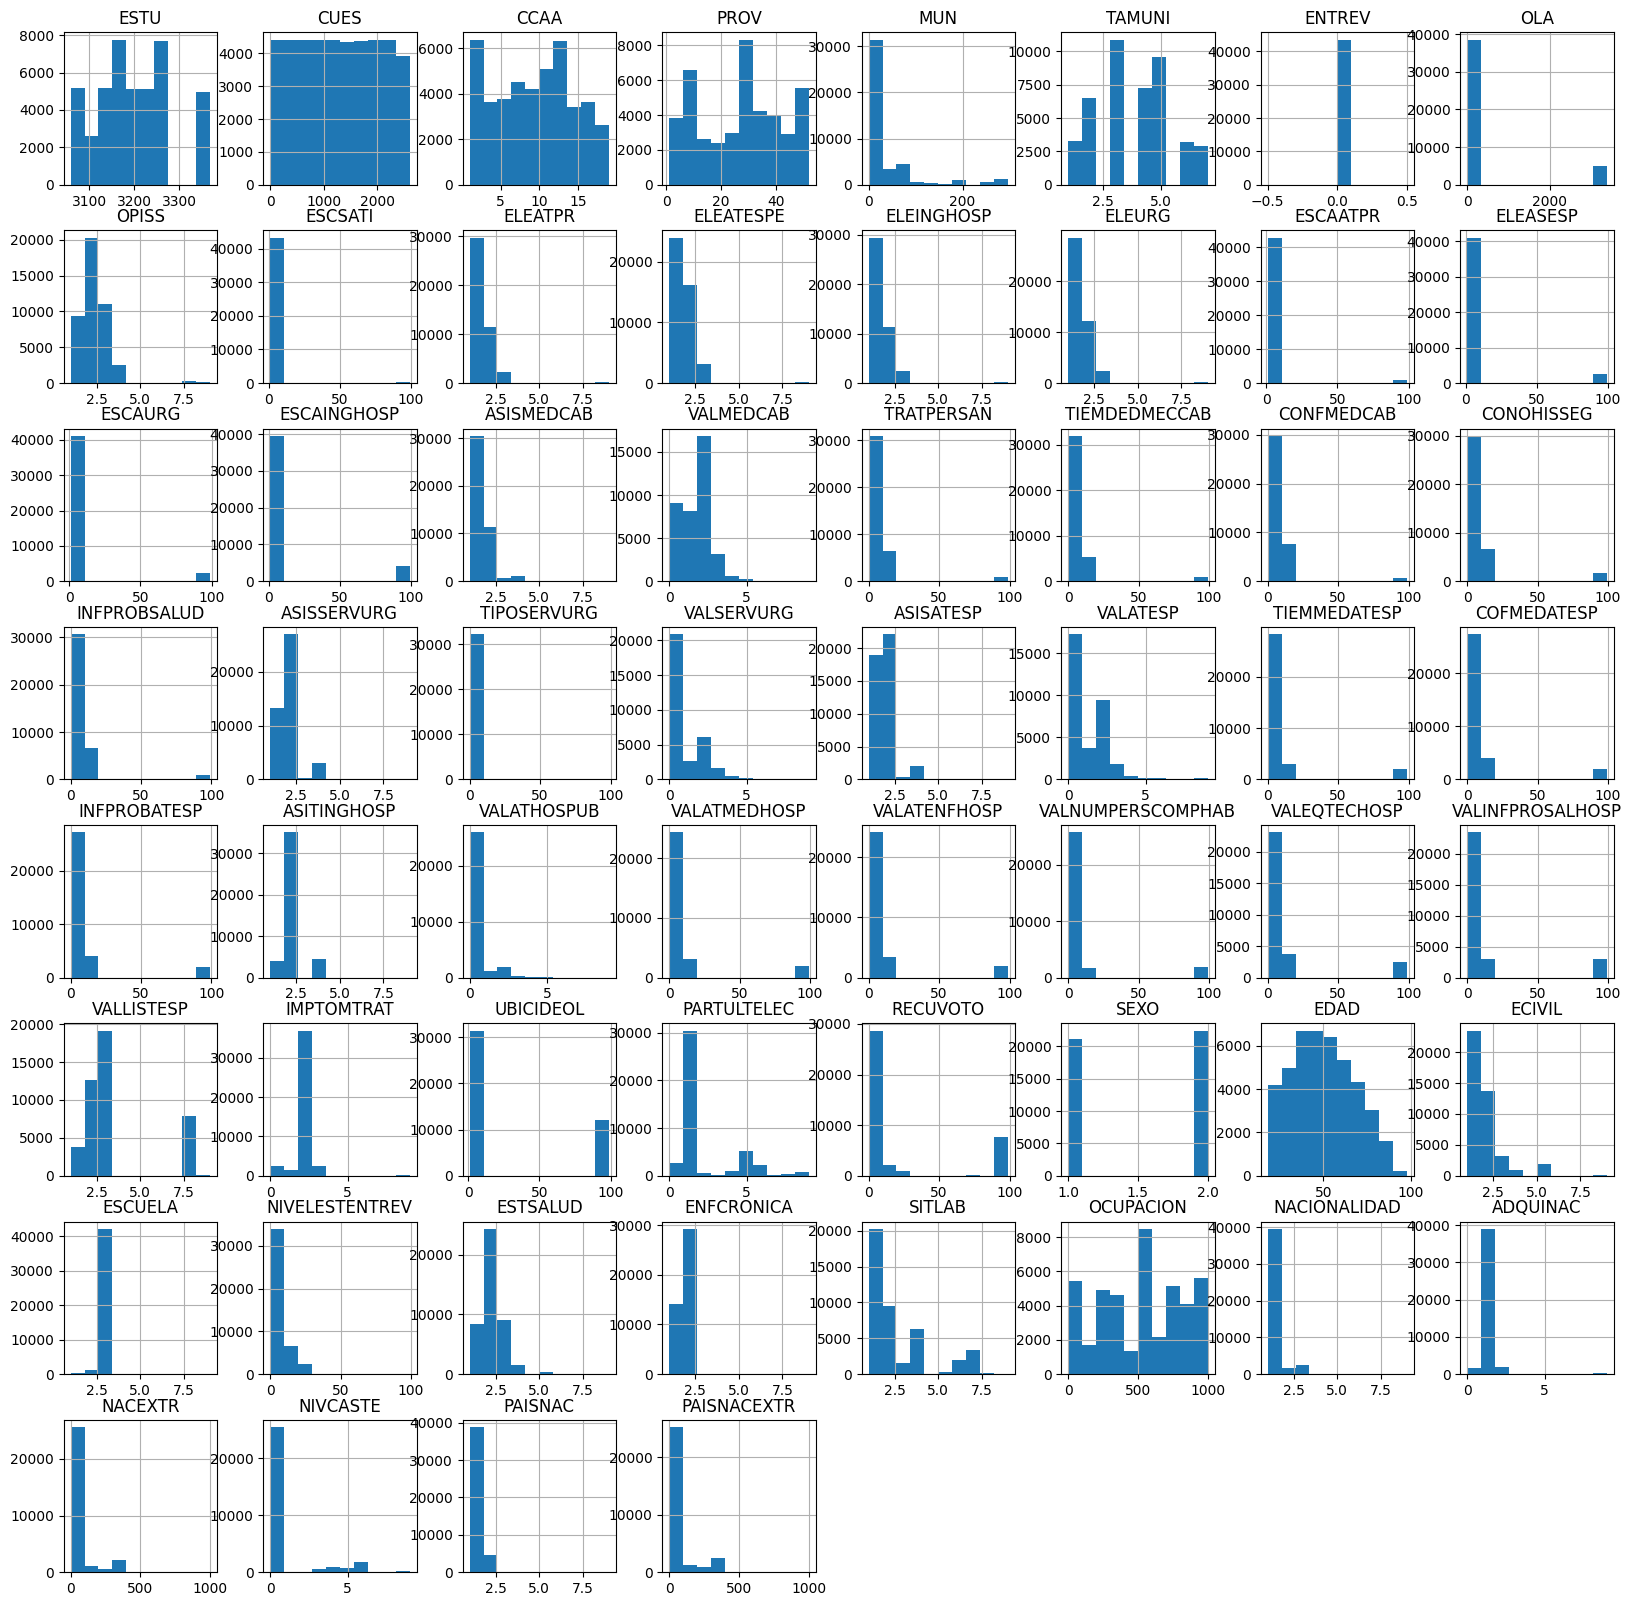

In [15]:
from matplotlib import pyplot as plt
_ =  df_extractor_concatenated.hist(figsize=(20,20))

#### <center> Verificación de la calidad de los datos

##### <center> Valores Nulos

In [16]:
pd.set_option('display.max_rows', df_extractor_concatenated.shape[0]+1)
df_extractor_concatenated.isna().sum().to_frame(name="Null Values")

,Null Values
ESTU,0
CUES,0
CCAA,0
PROV,0
MUN,0
TAMUNI,0
ENTREV,1
OLA,0
OPISS,0
ESCSATI,0


##### <center> Valores fuera de rango

##### <center> Boxplot

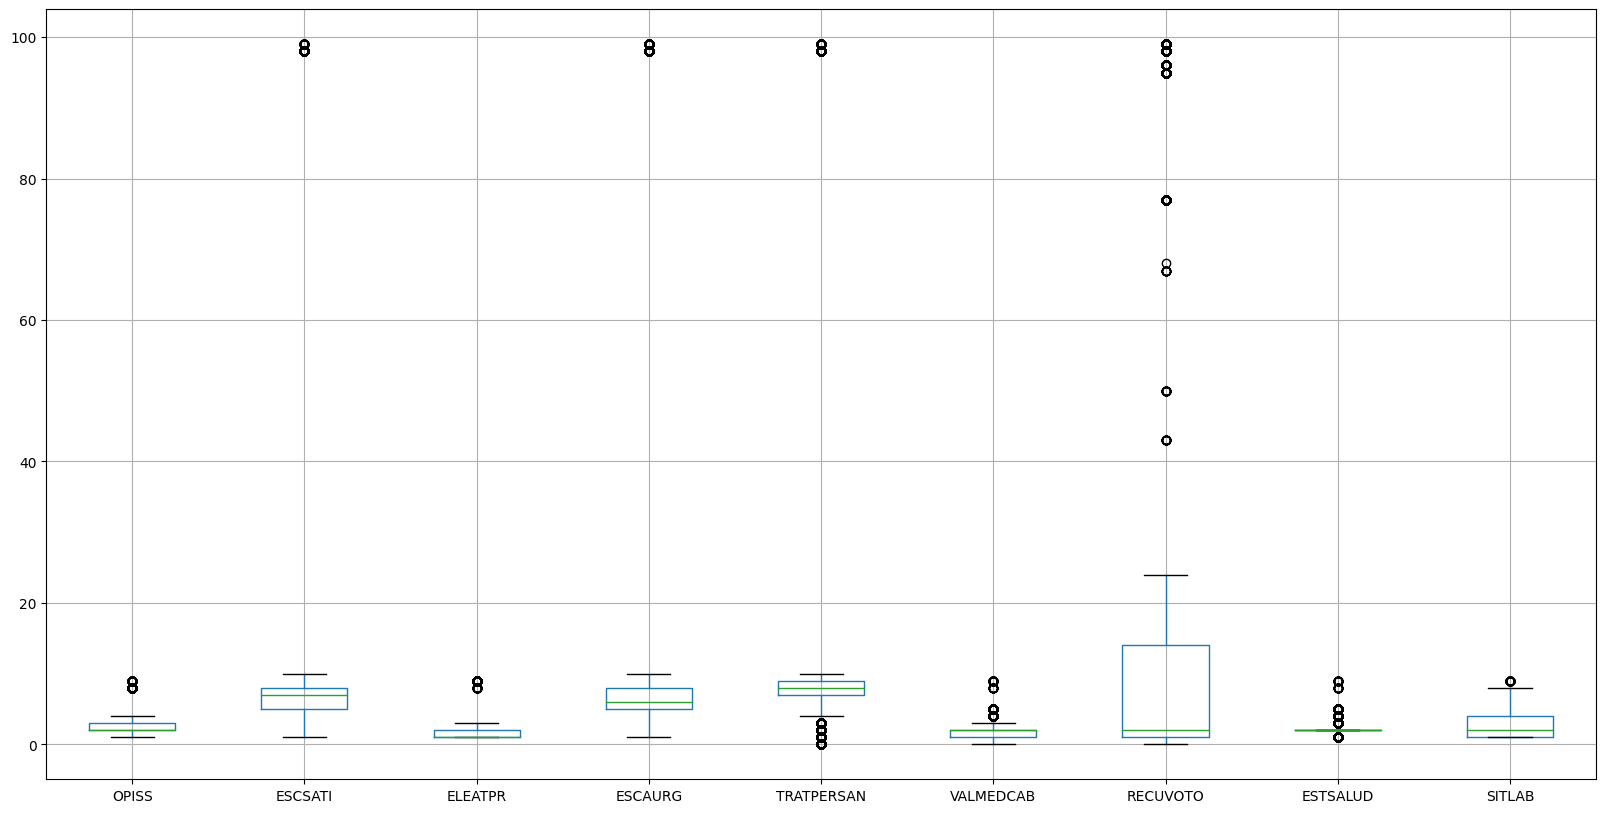

In [17]:
_ = df_extractor_concatenated[["OPISS", "ESCSATI", "ELEATPR", "ESCAURG", "TRATPERSAN", "VALMEDCAB", "RECUVOTO",  "ESTSALUD", "SITLAB"]].boxplot(figsize=(20,10))

### <center> Fase de preparación de los datos

#### <center> Limpieza de datos

##### <center> Tratamiento de NaNs

In [18]:
from pandas import DataFrame

def replace_null_by_value(df: DataFrame, value:  int):
    fillna_values = {
        "ESTU": value,
        "CUES": value,
        "CCAA": value,
        "PROV": value,
        "MUN": value,
        "TAMUNI": value,
        "ENTREV": value,
        "OLA": value,
        "OPISS": value,
        "ESCSATI": value,
        "ELEATPR": value,
        "ELEATESPE": value,
        "ELEINGHOSP": value,
        "ELEURG": value,
        "ESCAATPR": value,
        "ELEASESP": value,
        "ESCAURG": value,
        "ESCAINGHOSP": value,
        "ASISMEDCAB": value,
        "VALMEDCAB": value,
        "TRATPERSAN": value,
        "TIEMDEDMECCAB": value,
        "CONFMEDCAB": value,
        "CONOHISSEG": value,
        "INFPROBSALUD": value,
        "ASISSERVURG": value,
        "TIPOSERVURG": value,
        "VALSERVURG": value,
        "ASISATESP": value,
        "VALATESP": value,
        "TIEMMEDATESP": value,
        "COFMEDATESP": value,
        "INFPROBATESP": value,
        "ASITINGHOSP": value,
        "VALATHOSPUB": value,
        "VALATMEDHOSP": value,
        "VALATENFHOSP": value,
        "VALNUMPERSCOMPHAB": value,
        "VALEQTECHOSP": value,
        "VALINFPROSALHOSP": value,
        "VALLISTESP": value,
        "IMPTOMTRAT": value,
        "UBICIDEOL": value,
        "PARTULTELEC": value,
        "RECUVOTO": value,
        "SEXO": value,
        "EDAD": value,
        "ECIVIL": value,
        "ESCUELA": value,
        "NIVELESTENTREV": value,
        "ESTSALUD": value,
        "ENFCRONICA": value,
        "SITLAB": value,
        "OCUPACION": value,
        "NACIONALIDAD": value,
        "ADQUINAC": value,
        "NACEXTR": value,
        "NIVCASTE": value,
        "PAISNAC": value,
        "PAISNACEXTR": value
    }
    return df.fillna(value=fillna_values)

In [19]:
df_process_nan = replace_null_by_value(df_extractor_concatenated, 0)

##### <center> Tratamiento de los tipos de datos

In [20]:
import numpy as np

extractor_dtype = {
    "ESTU": np.int32,
    "CUES": np.int32,
    "CCAA": np.int32,
    "PROV": np.int32,
    "MUN": np.int32,
    "TAMUNI": np.int32,
    "ENTREV": np.int32,
    "OLA": np.int32,
    "OPISS": np.int32,
    "ESCSATI": np.int32,
    "ELEATPR": np.int32,
    "ELEATESPE": np.int32,
    "ELEINGHOSP": np.int32,
    "ELEURG": np.int32,
    "ESCAATPR": np.int32,
    "ELEASESP": np.int32,
    "ESCAURG": np.int32,
    "ESCAINGHOSP": np.int32,
    "ASISMEDCAB": np.int32,
    "VALMEDCAB": np.int32,
    "TRATPERSAN": np.int32,
    "TIEMDEDMECCAB": np.int32,
    "CONFMEDCAB": np.int32,
    "CONOHISSEG": np.int32,
    "INFPROBSALUD": np.int32,
    "ASISSERVURG": np.int32,
    "TIPOSERVURG": np.int32,
    "VALSERVURG": np.int32,
    "ASISATESP": np.int32,
    "VALATESP": np.int32,
    "TIEMMEDATESP": np.int32,
    "COFMEDATESP": np.int32,
    "INFPROBATESP": np.int32,
    "ASITINGHOSP": np.int32,
    "VALATHOSPUB": np.int32,
    "VALATMEDHOSP": np.int32,
    "VALATENFHOSP": np.int32,
    "VALNUMPERSCOMPHAB": np.int32,
    "VALEQTECHOSP": np.int32,
    "VALINFPROSALHOSP": np.int32,
    "VALLISTESP": np.int32,
    "IMPTOMTRAT": np.int32,
    "UBICIDEOL": np.int32,
    "PARTULTELEC": np.int32,
    "RECUVOTO": np.int32,
    "SEXO": np.int32,
    "EDAD": np.int32,
    "ECIVIL": np.int32,
    "ESCUELA": np.int32,
    "NIVELESTENTREV": np.int32,
    "ESTSALUD": np.int32,
    "ENFCRONICA": np.int32,
    "SITLAB": np.int32,
    "OCUPACION": np.int32,
    "NACIONALIDAD": np.int32,
    "ADQUINAC": np.int32,
    "NACEXTR": np.int32,
    "NIVCASTE": np.int32,
    "PAISNAC": np.int32,
    "PAISNACEXTR": np.int32,
    "FECHA": str
}


def apply_dtype(df: DataFrame, dtypes: dict):
    for column_name, data_type in dtypes.items():
        df[column_name] = df[column_name].astype(dtype=data_type)
    return df

In [21]:
df_process_dtype = apply_dtype(df_process_nan, extractor_dtype)

##### <center> Tratamiento de las variables FECHA y OLA

In [22]:
def split_fecha_ola(df: DataFrame):
    
    df_2022 = df.loc[(df.FECHA == "2022_1") | (df.FECHA == "2022_2") | (df.FECHA == "2022_3")]

    # https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
    df_2022[['FECHA', 'OLA']] = df_2022['FECHA'].str.split('_', expand=True)

    df_2022["FECHA"] = df_2022["FECHA"].astype("str")
    df_2022["OLA"] = df_2022["OLA"].astype("int32")

    return pd.concat(
        [df.loc[(df.FECHA != "2022_1") & (df.FECHA != "2022_2") & (df.FECHA != "2022_3")], df_2022],
        axis=0, ignore_index=True
    )

In [23]:
df_process_split_fecha_ola = split_fecha_ola(df_process_dtype)

##### <center> Tratamiento de las variables ASISMEDCAB, ASISSERVURG, ASISATESP y ASISINGHOSP

In [24]:
def replace_asis(df: DataFrame):

    df_2022 = df.loc[df.FECHA == "2022"]

    df_2022[["ASISMEDCAB", "ASISSERVURG", "ASISATESP", "ASITINGHOSP"]] = (
        df_2022[["ASISMEDCAB", "ASISSERVURG", "ASISATESP", "ASITINGHOSP"]].replace({2: 1, 3: 1, 4: 2})
    )

    return pd.concat([df.loc[df.FECHA != "2022"], df_2022], axis=0, ignore_index=True)

In [25]:
df_replace_asis = replace_asis(df_process_split_fecha_ola)

##### <center> Tratamiento del valor “Voto por correo”

In [26]:
def replace_part_elec(df: DataFrame):
    df["PARTULTELEC"] = df["PARTULTELEC"].replace({7: 1})
    return df

In [27]:
df_replace_part_elec = replace_part_elec(df_replace_asis)

##### <center> Mapeo de los Partidos Políticos

In [28]:
def norm_part_poli(df: DataFrame):
    maps_partido_politico = {
        "2015": {
            4: 22,
            6: 23,
            7: 11,
            9: 24,
            10: 23,
            11: 7,
            13: 15,
            14: 95,
            15: 96
        },
        "2016": {
            10: 11,
            7: 8,
            12: 13,
            6: 7,
            3: 21,
            5: 6,
            8: 16,
            9: 10,
            11: 20,
            13: 95,
            14: 96,
        },
        "2017": {
            10: 11,
            7: 8,
            12: 13,
            6: 7,
            3: 21,
            5: 6,
            8: 16,
            9: 10,
            11: 20,
            13: 95,
            14: 96,
        },
        "2018": {
            10: 11,
            7: 8,
            12: 13,
            6: 7,
            3: 21,
            5: 6,
            8: 16,
            9: 10,
            11: 20,
            13: 95,
            14: 96,
        },
        "2019": {
            12: 20
        },
        "2022": {
            12: 20
        }
    }

    df_clean_vi = []
    for ano, map_partido in maps_partido_politico.items():
        df_clean_vi_ano = df.loc[df["FECHA"] == ano]
        df_clean_vi_ano["RECUVOTO"] = df_clean_vi_ano["RECUVOTO"].replace(map_partido)
        df_clean_vi.append(df_clean_vi_ano)

    return pd.concat(df_clean_vi, axis=0, ignore_index=True)

In [29]:
df_norm_part_poli = norm_part_poli(df_replace_part_elec)

##### <center> Mapeo del Nivel de Estudios

In [30]:
def norm_niv_estu(df: DataFrame):
    map_nivelestentrev = {
        "2018": {
            1: 1,
            2: 2,
            3: 2,
            4: 2,
            5: 4,
            6: 4,
            7: 4,
            8: 4,
            9: 6,
            10: 6,
            11: 6,
            12: 3,
            13: 3,
            14: 5,
            15: 3,
            16: 5,
            17: 5,
            18: 5,
            19: 7,
            20: 7,
            21: 7,
            22: 7,
            23: 9,
            24: 10,
            25: 12,
            26: 15,
            27: 16
        }
    }

    for ano, map_n in map_nivelestentrev.items():
        df_clean_vii_ano = df.loc[df["FECHA"] == ano]
        df_clean_vii_ano["NIVELESTENTREV"] = df_clean_vii_ano["NIVELESTENTREV"].replace(map_n)
        df.loc[df["FECHA"] == ano] = df_clean_vii_ano

    return df

In [31]:
df_norm_niv_estu = norm_niv_estu(df_norm_part_poli)

##### <center> Tratamiento de outliers y valores atípicos ( reemplazo por mediana )

In [32]:
 def outliers(df: DataFrame):
    map_nulls = {'ADQUINAC': {0: df["ADQUINAC"].median(), 9: df["ADQUINAC"].median()},
                 'ASISATESP': {8: df["ASISATESP"].median(), 9: df["ASISATESP"].median()},
                 'ASISMEDCAB': {8: df["ASISMEDCAB"].median(), 9: df["ASISMEDCAB"].median()},
                 'ASISSERVURG': {8: df["ASISSERVURG"].median(), 9: df["ASISSERVURG"].median()},
                 'ASITINGHOSP': {9: df["ASITINGHOSP"].median()},
                 'COFMEDATESP': {0: df["COFMEDATESP"].median(), 98: df["COFMEDATESP"].median(),
                                 99: df["COFMEDATESP"].median()},
                 'CONFMEDCAB': {0: df["CONFMEDCAB"].median(), 98: df["CONFMEDCAB"].median(),
                                99: df["CONFMEDCAB"].median()},
                 'CONOHISSEG': {0: df["CONOHISSEG"].median(), 98: df["CONOHISSEG"].median(),
                                99: df["CONOHISSEG"].median()},
                 'ECIVIL': {9: df["ECIVIL"].median()},
                 'ELEASESP': {98: df["ELEASESP"].median(), 99: df["ELEASESP"].median()},
                 'ELEATESPE': {8: df["ELEATESPE"].median(), 9: df["ELEATESPE"].median()},
                 'ELEATPR': {8: df["ELEATPR"].median(), 9: df["ELEATPR"].median()},
                 'ELEINGHOSP': {8: df["ELEINGHOSP"].median(), 9: df["ELEINGHOSP"].median()},
                 'ELEURG': {8: df["ELEURG"].median(), 9: df["ELEURG"].median()},
                 'ENFCRONICA': {9: df["ENFCRONICA"].median()},
                 'ESCAATPR': {98: df["ESCAATPR"].median(), 99: df["ESCAATPR"].median()},
                 'ESCAINGHOSP': {98: df["ESCAINGHOSP"].median(), 99: df["ESCAINGHOSP"].median()},
                 'ESCAURG': {98: df["ESCAURG"].median(), 99: df["ESCAURG"].median()},
                 'ESCSATI': {98: df["ESCSATI"].median(), 99: df["ESCSATI"].median()},
                 'ESCUELA': {9: df["ESCUELA"].median()},
                 'ESTSALUD': {8: df["ESTSALUD"].median(), 9: df["ESTSALUD"].median()},
                 'IMPTOMTRAT': {0: df["IMPTOMTRAT"].median(), 9: df["IMPTOMTRAT"].median()},
                 'INFPROBATESP': {0: df["INFPROBATESP"].median(), 98: df["INFPROBATESP"].median(),
                                  99: df["INFPROBATESP"].median()},
                 'INFPROBSALUD': {0: df["INFPROBSALUD"].median(), 98: df["INFPROBSALUD"].median(),
                                  99: df["INFPROBSALUD"].median()},
                 'NACEXTR': {0: df["NACEXTR"].median(), 999: df["NACEXTR"].median()},
                 'NACIONALIDAD': {9: df["NACIONALIDAD"].median()},
                 'NIVCASTE': {0: df["NIVCASTE"].median(), 8: df["NIVCASTE"].median(), 9: df["NIVCASTE"].median()},
                 'NIVELESTENTREV': {0: df["NIVELESTENTREV"].median(), 98: df["NIVELESTENTREV"].median(),
                                    99: df["NIVELESTENTREV"].median()},
                 'OCUPACION': {0: df["OCUPACION"].median(), 998: df["OCUPACION"].median(),
                               999: df["OCUPACION"].median()},
                 'OPISS': {8: df["OPISS"].median(), 9: df["OPISS"].median()},
                 'PAISNAC': {9: df["PAISNAC"].median()},
                 'PAISNACEXTR': {0: df["PAISNACEXTR"].median(), 999: df["PAISNACEXTR"].median()},
                 'PARTULTELEC': {0: df["PARTULTELEC"].median(), 8: df["PARTULTELEC"].median(),
                                 9: df["PARTULTELEC"].median()},
                 'RECUVOTO': {0: df["RECUVOTO"].median(), 98: df["RECUVOTO"].median(), 99: df["RECUVOTO"].median()},
                 'SITLAB': {9: df["SITLAB"].median()},
                 'TIEMDEDMECCAB': {0: df["TIEMDEDMECCAB"].median(), 98: df["TIEMDEDMECCAB"].median(),
                                   99: df["TIEMDEDMECCAB"].median()},
                 'TIEMMEDATESP': {0: df["TIEMMEDATESP"].median(), 98: df["TIEMMEDATESP"].median(),
                                  99: df["TIEMMEDATESP"].median()},
                 'TIPOSERVURG': {0: df["TIPOSERVURG"].median(), 98: df["TIPOSERVURG"].median(),
                                 99: df["TIPOSERVURG"].median()},
                 'TRATPERSAN': {0: df["TRATPERSAN"].median(), 98: df["TRATPERSAN"].median(),
                                99: df["TRATPERSAN"].median()},
                 'UBICIDEOL': {98: df["UBICIDEOL"].median(), 99: df["UBICIDEOL"].median()},
                 'VALATENFHOSP': {0: df["VALATENFHOSP"].median(), 98: df["VALATENFHOSP"].median(),
                                  99: df["VALATENFHOSP"].median()},
                 'VALATESP': {0: df["VALATESP"].median(), 8: df["VALATESP"].median(), 9: df["VALATESP"].median()},
                 'VALATHOSPUB': {0: df["VALATHOSPUB"].median(), 8: df["VALATHOSPUB"].median(),
                                 9: df["VALATHOSPUB"].median()},
                 'VALATMEDHOSP': {0: df["VALATMEDHOSP"].median(), 98: df["VALATMEDHOSP"].median(),
                                  99: df["VALATMEDHOSP"].median()},
                 'VALEQTECHOSP': {0: df["VALEQTECHOSP"].median(), 98: df["VALEQTECHOSP"].median(),
                                  99: df["VALEQTECHOSP"].median()},
                 'VALINFPROSALHOSP': {0: df["VALINFPROSALHOSP"].median(), 98: df["VALINFPROSALHOSP"].median(),
                                      99: df["VALINFPROSALHOSP"].median()},
                 'VALLISTESP': {8: df["VALLISTESP"].median(), 9: df["VALLISTESP"].median()},
                 'VALMEDCAB': {0: df["VALMEDCAB"].median(), 8: df["VALMEDCAB"].median(), 9: df["VALMEDCAB"].median()},
                 'VALNUMPERSCOMPHAB': {0: df["VALNUMPERSCOMPHAB"].median(), 98: df["VALNUMPERSCOMPHAB"].median(),
                                       99: df["VALNUMPERSCOMPHAB"].median()},
                 'VALSERVURG': {0: df["VALSERVURG"].median(), 8: df["VALSERVURG"].median(),
                                9: df["VALSERVURG"].median()}}

    for col, map_values in map_nulls.items():
        df[col] = df[col].replace(map_nulls[col])

    return df

In [33]:
df_outliers = outliers(df_norm_niv_estu)

In [34]:
df_clean = df_outliers
df_clean["FECHA"] = df_clean["FECHA"].astype("int32")

##### <center> Cantidad de Valores Atípicos (0) Por Columna 

In [35]:
import matplotlib.pyplot as plt

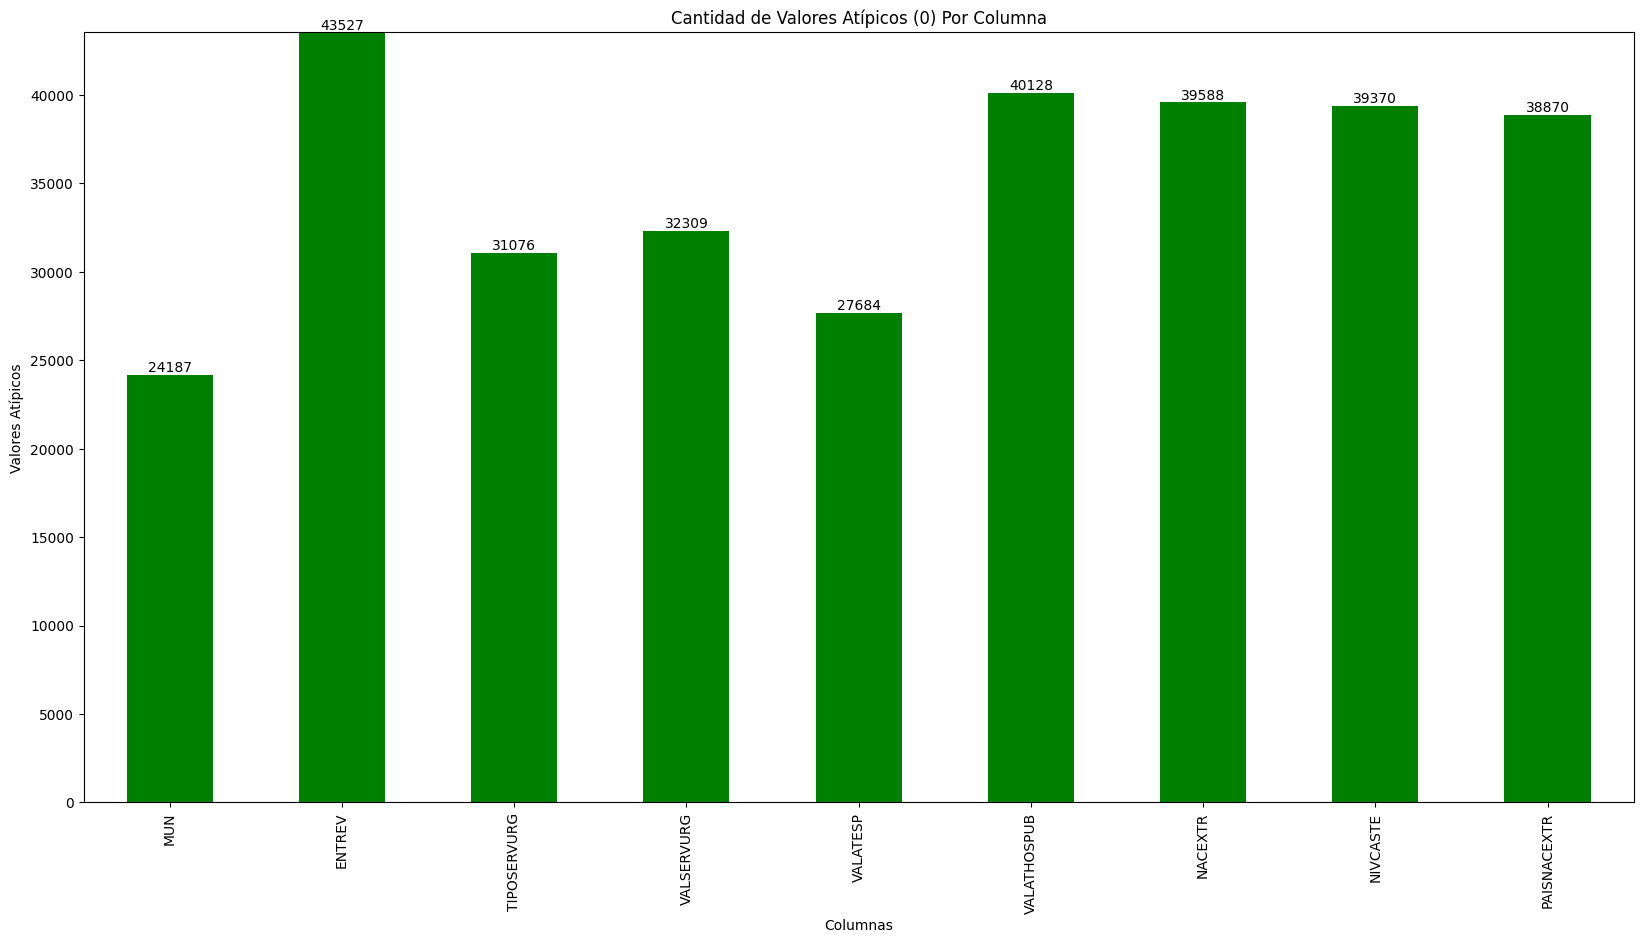

In [36]:
columns = df_clean.columns.to_list()

eda_i_data = []

for col in columns:
    result = df_clean.loc[df_clean[col] == 0][col]
    if result.shape[0] > 0:
        eda_i_data.append([col, result.shape[0]])

df_eda_tech_i = pd.DataFrame(data=eda_i_data, columns=["column", "missing_values"])

# representamos los resultados en un gráfico de barras
ax = df_eda_tech_i.plot.bar(
    x="column",
    y="missing_values",
    title="Cantidad de Valores Atípicos (0) Por Columna",
    legend=False,
    xlabel="Columnas",
    ylabel="Valores Atípicos",
    ylim=(0, df_clean.shape[0]),
    color="green",
    figsize=(20,10)
)

# annotate bars
ax.bar_label(ax.containers[0])

_ = ax

#### <center> Análisis de Datos - Visualización

##### <center> Media de la Escala de Satisfacción del Sistema Sanitario por Año

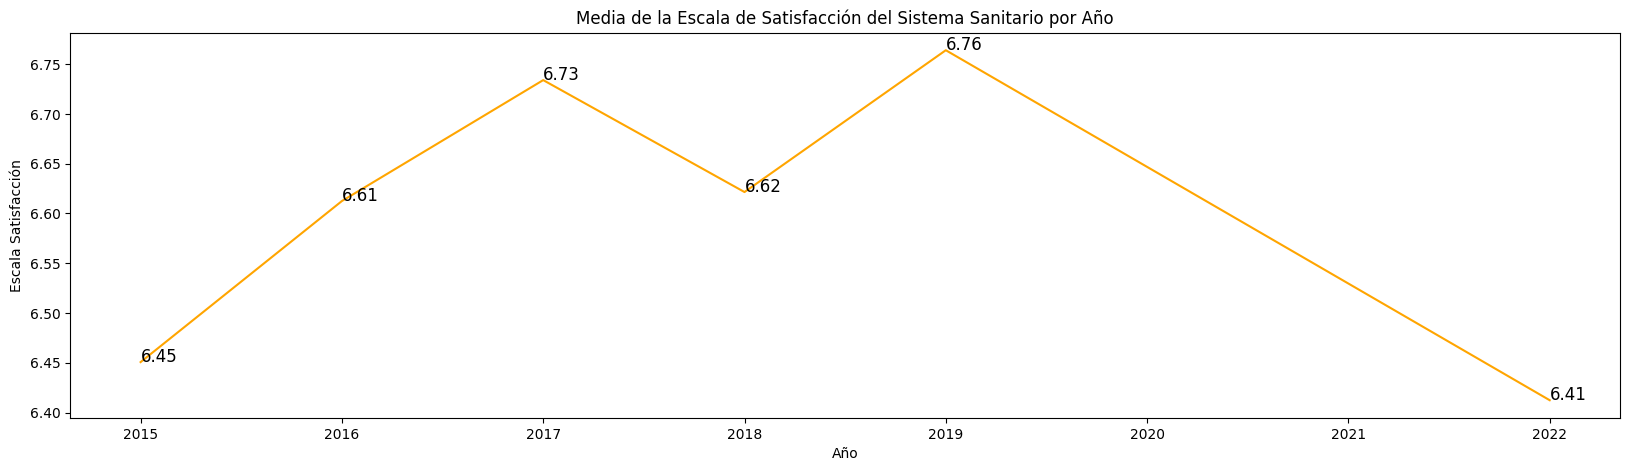

In [37]:
df_eda_func_i = (df_clean
                 .query("(ESCSATI != 98) & (ESCSATI != 99)")
                 .groupby("FECHA")
                 .agg({"ESCSATI": "mean"})
                 .reset_index())

xticks = df_eda_func_i["FECHA"].values

ax = df_eda_func_i.reset_index().plot.line(
    x="FECHA",
    y="ESCSATI",
    title="Media de la Escala de Satisfacción del Sistema Sanitario por Año",
    legend=False,
    xlabel="Año",
    ylabel="Escala Satisfacción",
    color="orange",
    figsize=(20,5)
)

for index in range(len(df_eda_func_i["FECHA"].values)):
    x = df_eda_func_i["FECHA"][index]
    y = df_eda_func_i["ESCSATI"][index]
    value = round(y, 2)
    ax.text(x, y, value, size=12)
    
_ = ax

##### <center> Porcentaje del Nivel de Satisfacción de la Sanidad Pública

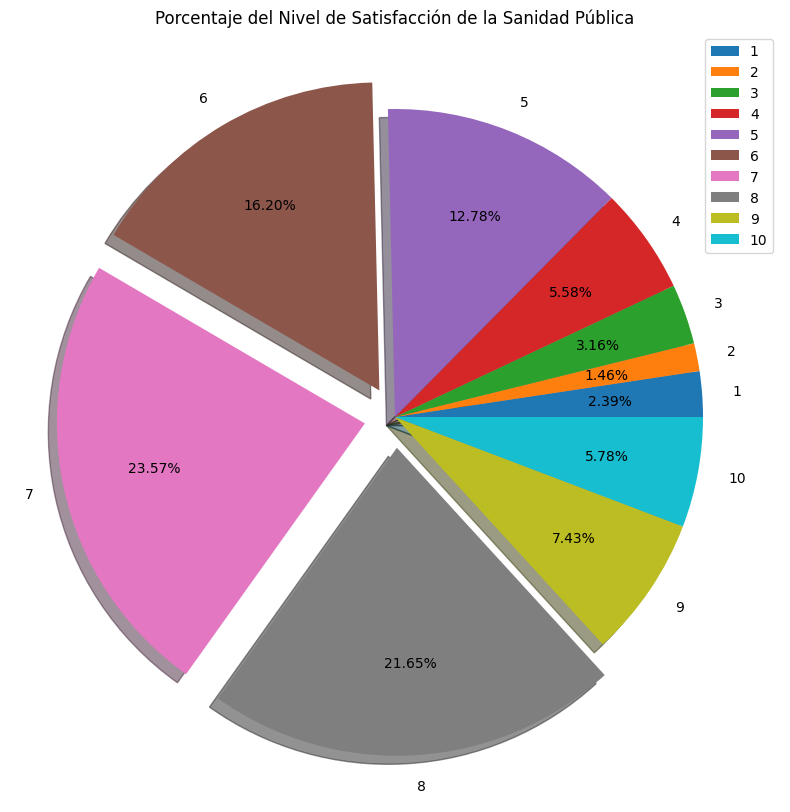

In [38]:
df_eda_func_ii = (df_clean
                  .query("(ESCSATI != 98) & (ESCSATI != 99)")["ESCSATI"]
                  .value_counts()
                  .reset_index())

df_eda_func_ii["percent"] = (df_eda_func_ii["ESCSATI"] / df_eda_func_ii["ESCSATI"].sum()) * 100

df_eda_func_ii = df_eda_func_ii.sort_values(by=["index"], axis=0)

xticks = df_eda_func_ii["index"].values

df_eda_func_ii["ESCSATI"] = df_eda_func_ii["ESCSATI"]

_ = df_eda_func_ii.plot.pie(
    y="ESCSATI",
    autopct='%1.2f%%',
    labels=df_eda_func_ii["index"],
    explode=[0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0, 0],
    shadow=True,
    pctdistance=0.7,
    labeldistance=1.1,
    legend=True,
    ylabel="",
    title="Porcentaje del Nivel de Satisfacción de la Sanidad Pública",
    figsize=(10, 10)
)

##### <center> Escala de Satisfacción Servicios Sanidad Pública

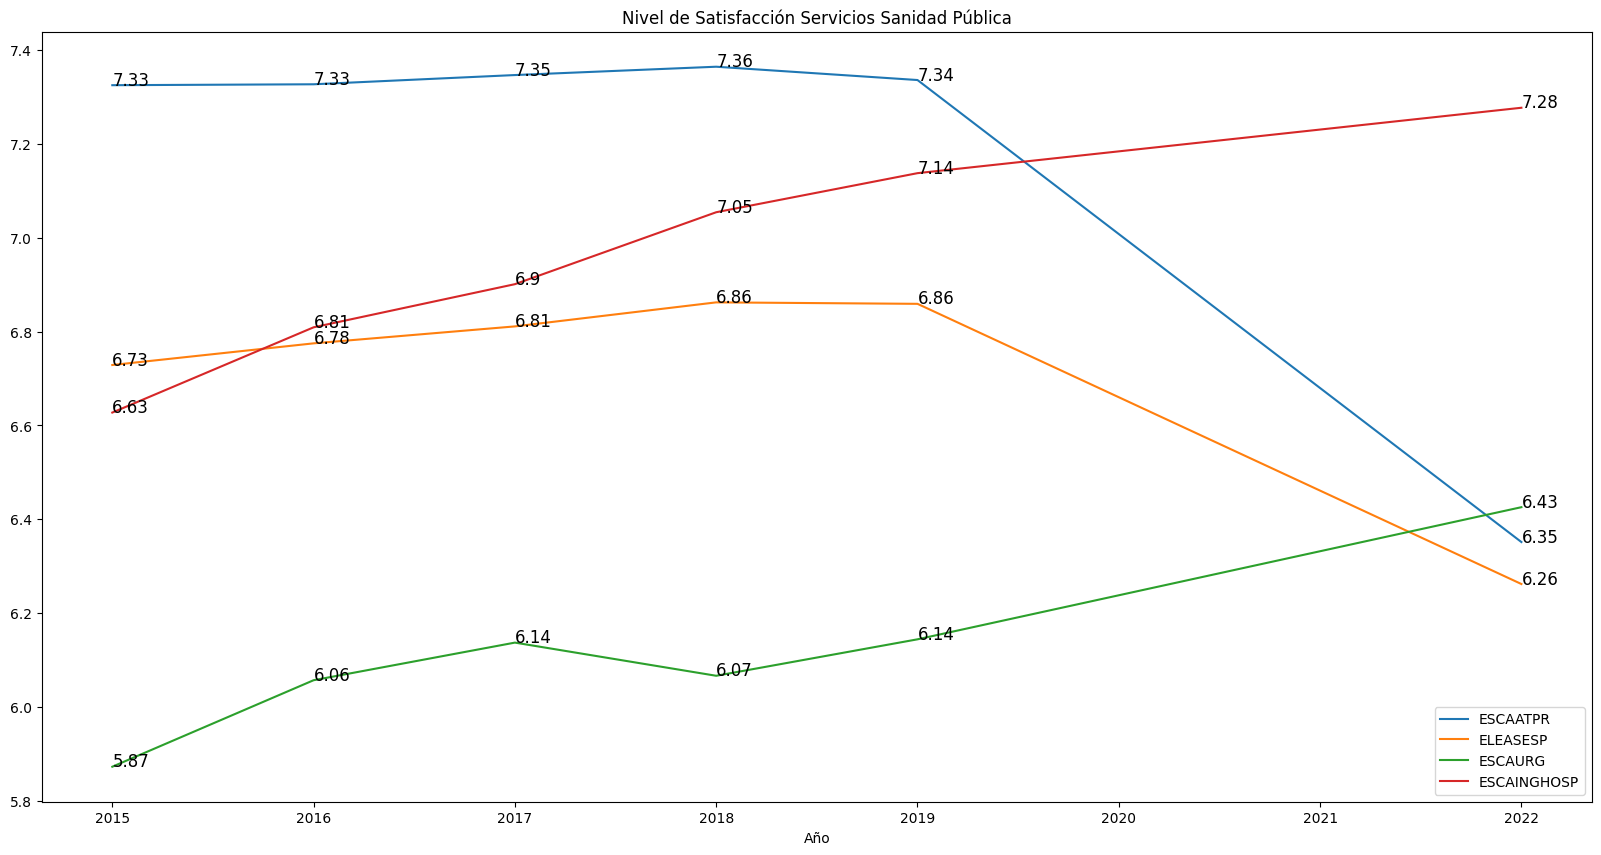

In [39]:
df_eda_func_iii = (df_clean
                   .query("(ESCAATPR != 98) & (ESCAATPR != 99)")
                   .query("(ELEASESP != 98) & (ELEASESP != 99)")
                   .query("(ESCAURG != 98) & (ESCAURG != 99)")
                   .query("(ESCAINGHOSP != 98) & (ESCAINGHOSP != 99)")
                   .groupby("FECHA").agg({"ESCAATPR": "mean",
                                          "ELEASESP": "mean",
                                          "ESCAURG": "mean",
                                          "ESCAINGHOSP": "mean"})
                   .reset_index())

x = df_eda_func_iii["FECHA"].values

ax = df_eda_func_iii.plot("FECHA",
                          legend=True,
                          xlabel="Año",
                          title="Nivel de Satisfacción Servicios Sanidad Pública",
                          figsize=(20,10)
                         )

for index in range(len(df_eda_func_iii["FECHA"].values)):
    x = df_eda_func_iii["FECHA"][index]
    y_values = df_eda_func_iii[["ESCAATPR", "ELEASESP", "ESCAURG", "ESCAINGHOSP"]].values[index]
    for y_val in y_values:
        ax.text(x, y_val, round(y_val, 2), size=12)
_ = ax

##### <center> Media de nivel Satisfacción de la Sanidad Pública por Partido Político

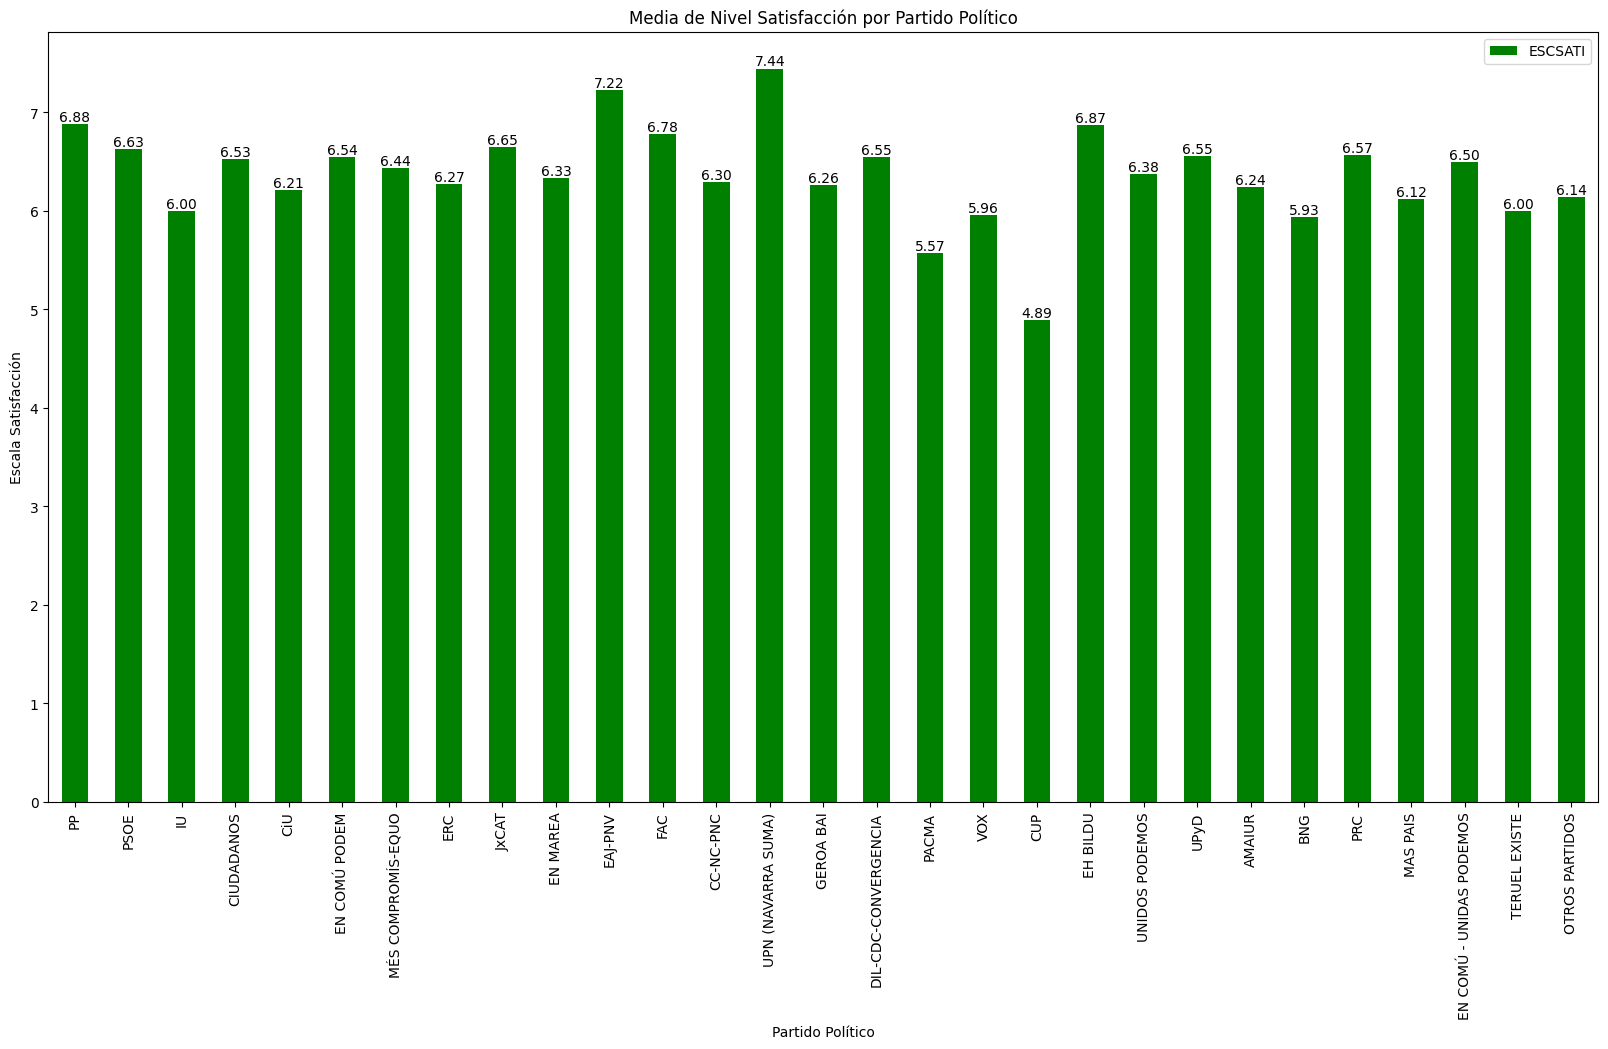

In [40]:
df_eda_func_iv = (df_clean
                  .query(
    "(RECUVOTO > 0) & (RECUVOTO != 77) & (RECUVOTO != 96) & (RECUVOTO != 97) & (RECUVOTO != 98) & (RECUVOTO != 99)")
                  .query("(ESCSATI != 98) & (ESCSATI != 99)")
                  .groupby("RECUVOTO").agg({"ESCSATI": "mean"})
                  .reset_index())

map_partido = {
    1: "PP",
    2: "PSOE",
    3: "IU",
    22: "UPyD",
    5: "CiU",
    23: "AMAIUR",
    11: "EAJ-PNV",
    8: "ERC",
    24: "BNG",
    13: "CC-NC-PNC",
    7: "MÉS COMPROMÍS-EQUO",
    12: "FAC",
    15: "GEROA BAI",
    21: "UNIDOS PODEMOS",
    4: "CIUDADANOS",
    6: "EN COMÚ PODEM",
    16: "DIL-CDC-CONVERGENCIA",
    10: "EN MAREA",
    20: "EH BILDU",
    18: "VOX",
    9: "JxCAT",
    14: "UPN (NAVARRA SUMA)",
    43: "PRC",
    17: "PACMA",
    19: "CUP",
    50: "MAS PAIS",
    67: "EN COMÚ - UNIDAS PODEMOS",
    68: "TERUEL EXISTE",
    95: "OTROS PARTIDOS"
}
df_eda_func_iv["RECUVOTO"] = df_eda_func_iv["RECUVOTO"].replace(map_partido)

y_values = list(map(lambda x: round(x), df_eda_func_iv["ESCSATI"].values))

# representamos los resultados en un gráfico de barras
ax = df_eda_func_iv.plot.bar(
    x="RECUVOTO",
    y="ESCSATI",
    title="Media de Nivel Satisfacción por Partido Político",
    legend=True,
    xlabel="Partido Político",
    ylabel="Escala Satisfacción",
    color="green",
    figsize=(20,10)
)

# annotate bars
ax.bar_label(ax.containers[0], fmt="%.2f")

_ = ax

##### <center> Nivel satisfacción por Provincias

In [41]:
df_satis = df_clean.groupby(["FECHA", "CCAA", "PROV"]).agg({"ESCSATI": "mean"}).reset_index()
df_satis.head()

,FECHA,CCAA,PROV,ESCSATI
0,2015,1,4,6.518519
1,2015,1,11,6.242718
2,2015,1,14,6.690141
3,2015,1,18,6.273684
4,2015,1,21,6.181818


In [42]:
import geopandas as gpd
map_data = gpd.read_file("resources/data/geo/natalidad.geojson")
map_data["CC_2"] = map_data["CC_2"].astype(int)

In [43]:
eda_viii = map_data.merge(df_satis, how='inner', left_on='CC_2', right_on='PROV', indicator=True)[["NAME_1", "NAME_2", "CC_2", "geometry", "FECHA", "ESCSATI"]]
eda_viii.head()

,NAME_1,NAME_2,CC_2,geometry,FECHA,ESCSATI
0,Andalucía,Almería,4,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",2015,6.518519
1,Andalucía,Almería,4,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",2016,6.863636
2,Andalucía,Almería,4,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",2017,6.655556
3,Andalucía,Almería,4,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",2018,6.654321
4,Andalucía,Almería,4,"MULTIPOLYGON (((-3.03042 35.94236, -3.03042 35...",2019,6.797101


In [44]:
def plot_cmap_by_date(f):
    eda_viii_fecha = eda_viii.loc[eda_viii["FECHA"] == f]
    
    # Control del tamaño de la figura del mapa
    fig, ax = plt.subplots(figsize=(20, 10))

    # Control del título y los ejes
    ax.set_title(f"Nivel satisfacción por Provincias - {f}",
                 pad=20,
                 fontdict={'fontsize': 20, 'color': '#4873ab'})
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

    # Mostrar el mapa finalizado
    ax = eda_viii_fecha.plot(
        column='ESCSATI',
        ax = ax,
        cmap='plasma',
        zorder=5,
        legend=True        
    )
        
    return ax

###### <center> 2015

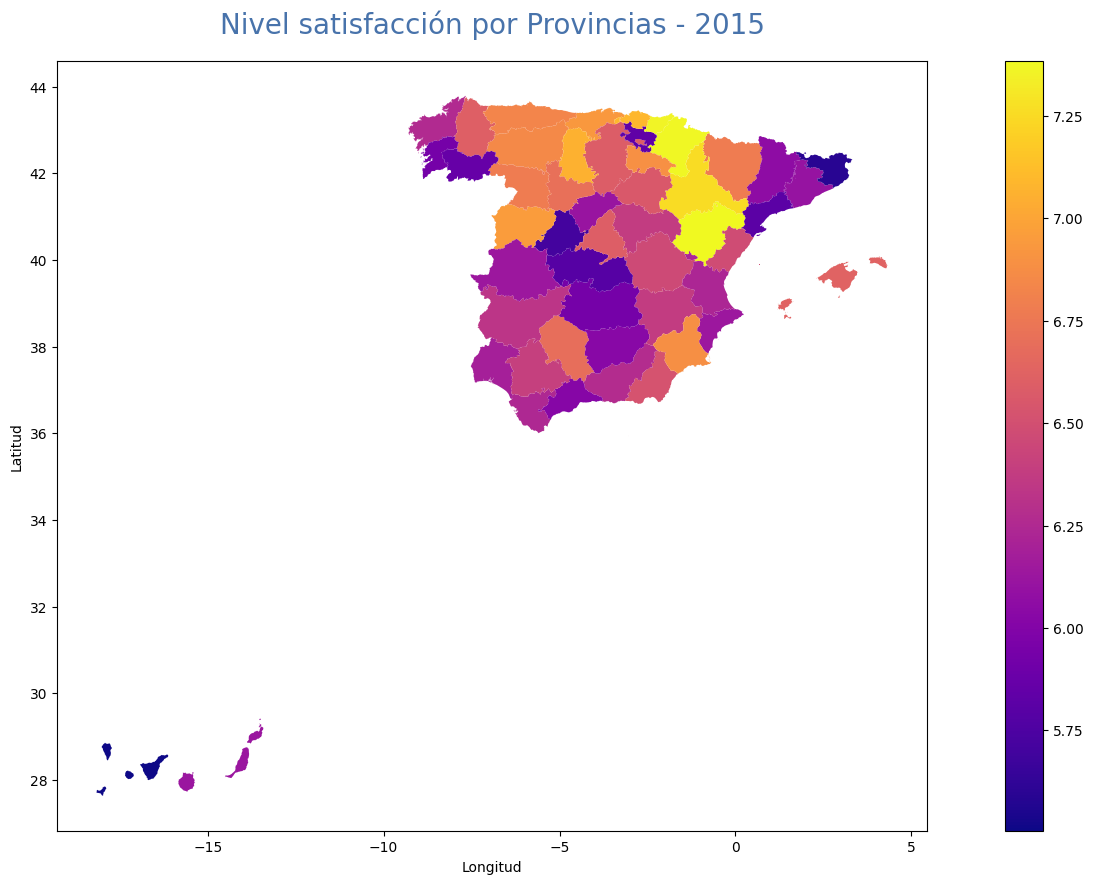

In [45]:
_ = plot_cmap_by_date(2015)

###### <center> 2016

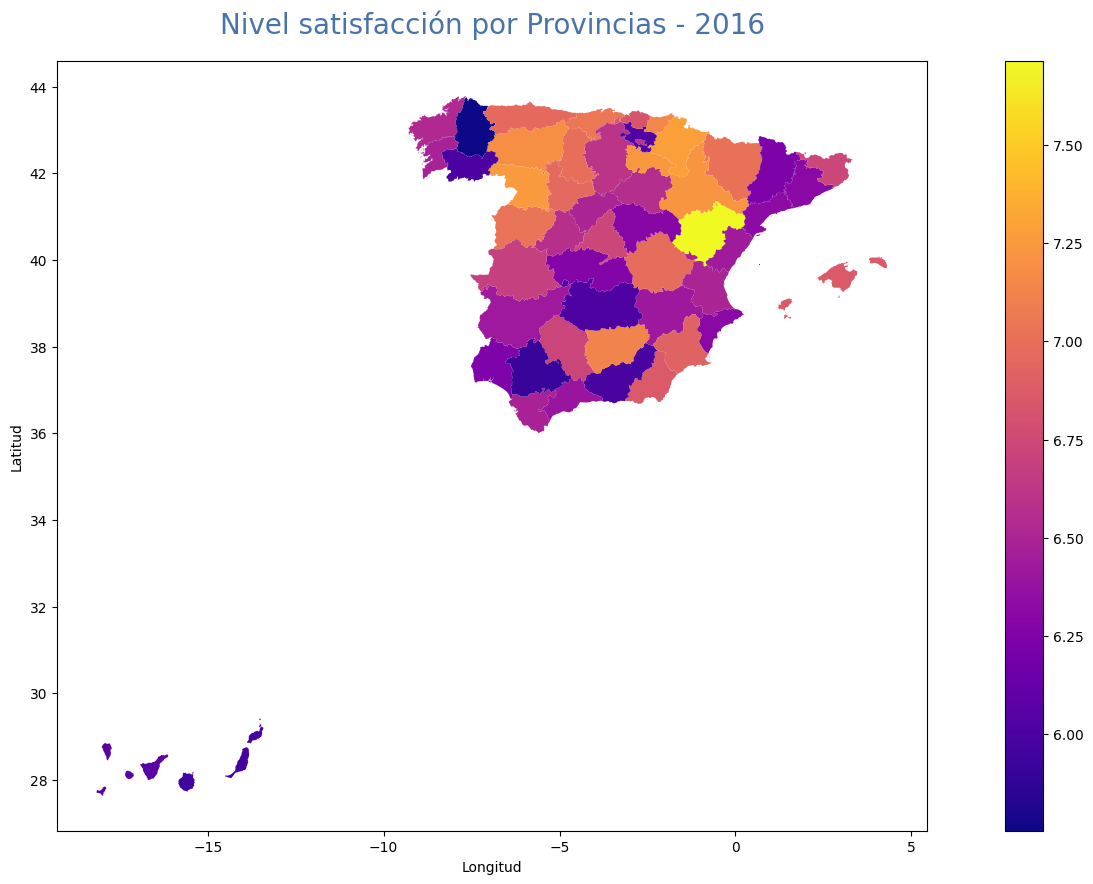

In [46]:
_ = plot_cmap_by_date(2016)

###### <center> 2017

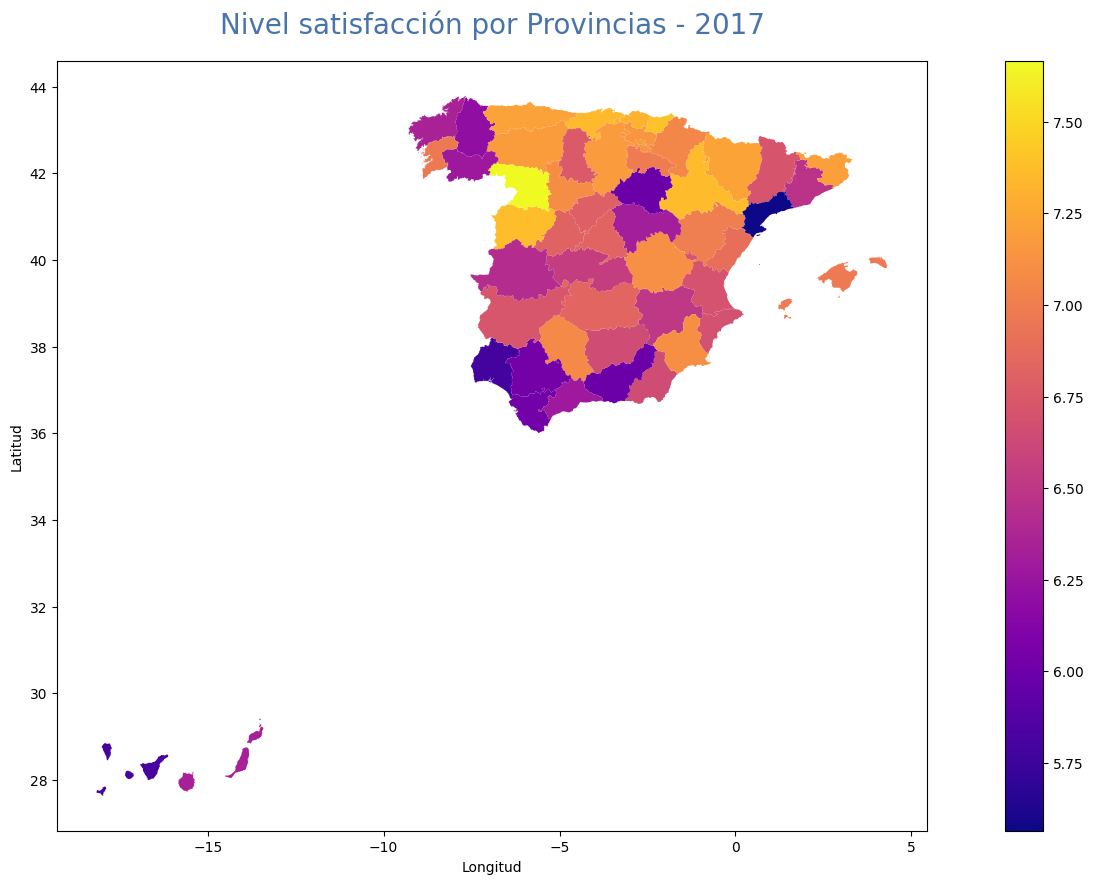

In [47]:
_ = plot_cmap_by_date(2017)

###### <center> 2018

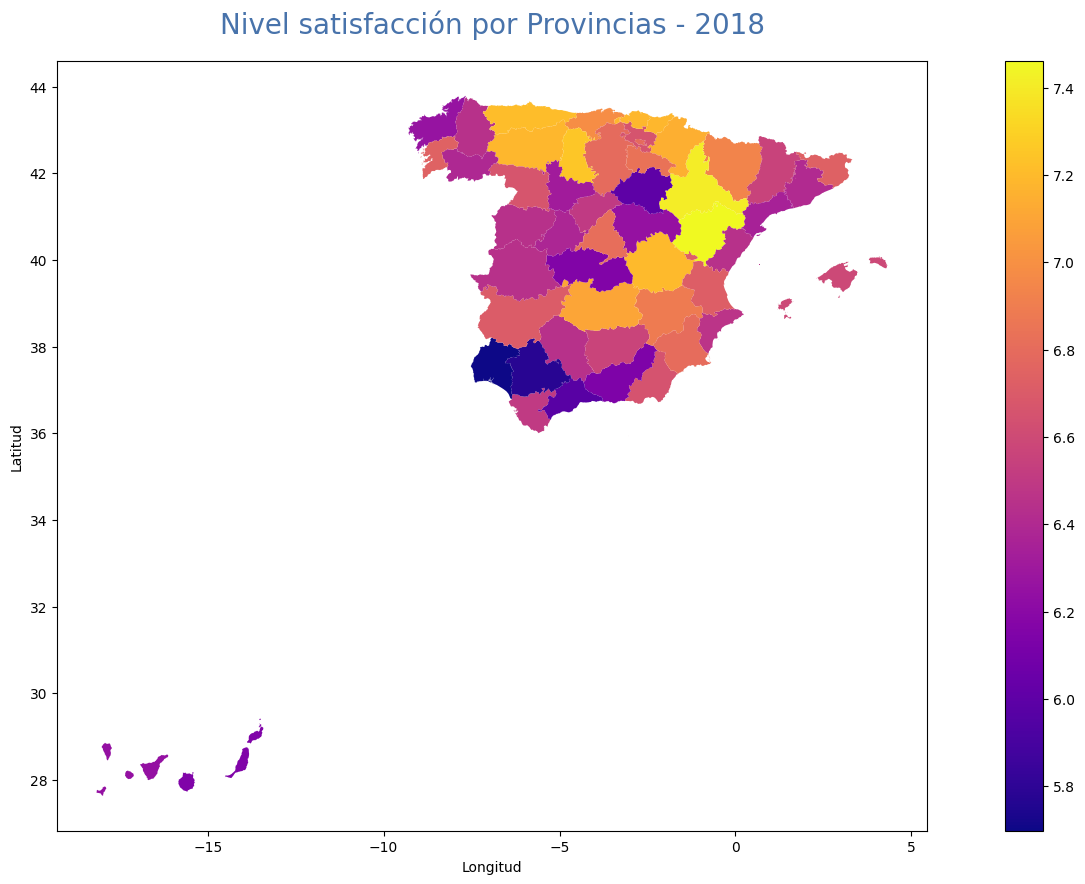

In [48]:
_ = plot_cmap_by_date(2018)

###### <center> 2019

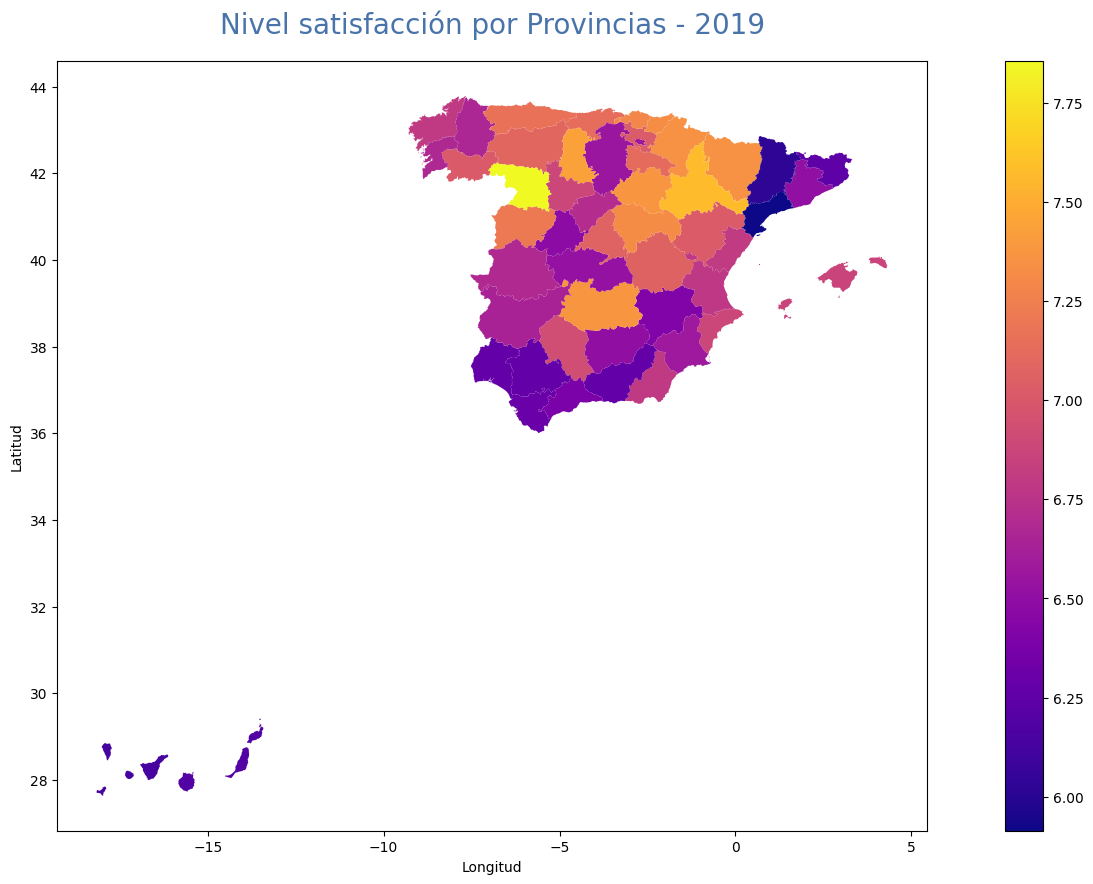

In [49]:
_ = plot_cmap_by_date(2019)

###### <center> 2022

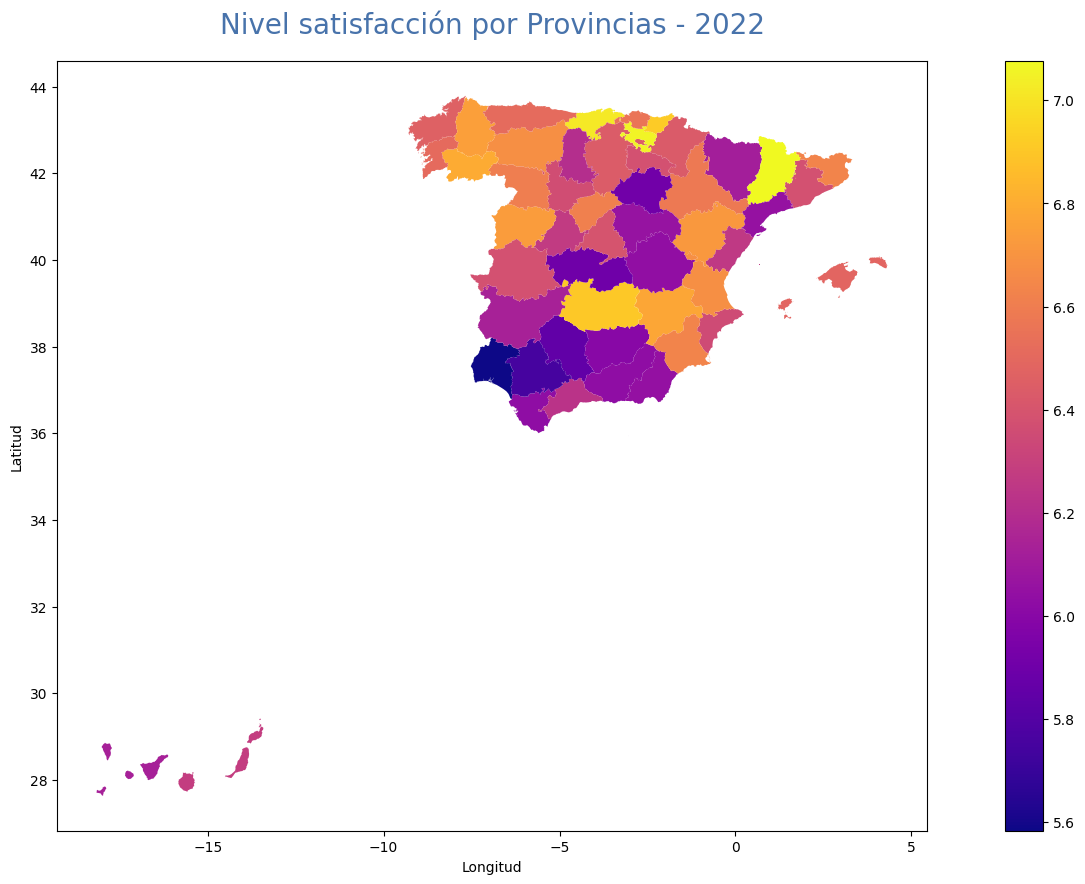

In [50]:
_ = plot_cmap_by_date(2022)

### <center> Fase de Modelado

#### <center> Selección de Variables

##### <center> Selección de Variables basada en el Método de Filtro

###### <center> Correlación de Variables

In [51]:
df_clean.corr().style.background_gradient(cmap='coolwarm')

,ESTU,CUES,CCAA,PROV,MUN,TAMUNI,ENTREV,OLA,OPISS,ESCSATI,ELEATPR,ELEATESPE,ELEINGHOSP,ELEURG,ESCAATPR,ELEASESP,ESCAURG,ESCAINGHOSP,ASISMEDCAB,VALMEDCAB,TRATPERSAN,TIEMDEDMECCAB,CONFMEDCAB,CONOHISSEG,INFPROBSALUD,ASISSERVURG,TIPOSERVURG,VALSERVURG,ASISATESP,VALATESP,TIEMMEDATESP,COFMEDATESP,INFPROBATESP,ASITINGHOSP,VALATHOSPUB,VALATMEDHOSP,VALATENFHOSP,VALNUMPERSCOMPHAB,VALEQTECHOSP,VALINFPROSALHOSP,VALLISTESP,IMPTOMTRAT,UBICIDEOL,PARTULTELEC,RECUVOTO,SEXO,EDAD,ECIVIL,ESCUELA,NIVELESTENTREV,ESTSALUD,ENFCRONICA,SITLAB,OCUPACION,NACIONALIDAD,ADQUINAC,NACEXTR,NIVCASTE,PAISNAC,PAISNACEXTR,FECHA
ESTU,1.000000,-0.023240,-0.030227,-0.031636,0.008448,0.013993,nan,-0.010728,0.028527,0.006164,-0.026910,-0.047438,-0.081126,-0.065001,-0.111769,-0.046742,0.062296,0.104120,-0.031640,0.025486,0.065291,-0.013840,0.027275,0.003833,0.024521,-0.029480,-0.039863,0.021741,-0.050376,0.013660,-0.031775,0.016501,0.025984,0.002162,-0.013849,-0.424764,-0.301514,-0.403978,-0.354278,-0.384823,-0.025506,0.090784,0.025571,-0.019850,0.036784,0.012988,0.047914,0.041212,0.029836,0.124731,-0.007347,-0.079686,-0.067752,-0.279880,0.006103,0.029790,0.025105,0.032715,0.016969,0.026994,0.985338
CUES,-0.023240,1.000000,0.221032,0.567763,0.092201,0.036344,nan,0.007688,-0.021135,0.003485,0.011092,0.014520,0.002251,0.017852,-0.013183,-0.024097,-0.019473,-0.017658,0.009539,-0.015585,-0.012816,-0.017152,-0.006441,0.001074,0.003138,0.026338,-0.011215,-0.022936,0.013326,-0.013176,-0.023687,0.009781,0.016824,0.010448,-0.008107,0.002193,-0.008643,-0.000796,-0.008009,0.007525,0.004807,-0.003855,0.025540,-0.008850,0.008823,-0.003318,-0.012944,-0.003915,0.012960,0.024285,-0.028712,0.023318,0.007113,-0.026929,-0.024241,0.014035,-0.020148,-0.016517,-0.007460,-0.009890,-0.024760
CCAA,-0.030227,0.221032,1.000000,0.164128,-0.097086,0.045203,nan,0.009771,-0.042176,0.007002,0.011802,0.015410,0.020459,0.020270,-0.010580,-0.009747,-0.026997,-0.011305,0.001312,-0.002503,-0.026329,-0.018527,-0.023236,-0.017766,-0.024050,0.015415,-0.003729,-0.006905,-0.025157,0.009863,-0.007114,-0.010781,-0.006958,0.005298,-0.003093,-0.019770,-0.028199,0.033849,-0.062262,-0.035094,0.008887,0.003131,0.005720,0.017250,0.004129,-0.002608,-0.016092,-0.024159,0.026041,0.043488,-0.011312,0.016582,-0.008554,-0.048057,0.022437,0.039451,0.031872,0.034175,0.042039,0.042764,-0.032468
PROV,-0.031636,0.567763,0.164128,1.000000,0.216549,0.043112,nan,0.005051,-0.016070,0.003117,0.024559,0.022882,0.004894,0.024327,-0.008978,-0.013849,-0.019710,-0.009012,0.011197,-0.023703,-0.007406,-0.010363,0.002258,0.009907,0.008995,0.018502,-0.007861,-0.015869,0.004089,-0.008398,-0.018328,0.014743,0.024034,0.007482,-0.008973,0.006533,-0.004431,0.007676,-0.004437,0.009605,0.001868,0.003620,0.064738,-0.017928,0.001087,-0.002968,-0.008346,-0.004528,0.016093,0.029088,-0.032534,0.019897,0.031729,-0.024934,-0.031987,0.012918,-0.031183,-0.022239,-0.012306,-0.016067,-0.031315
MUN,0.008448,0.092201,-0.097086,0.216549,1.000000,0.536698,nan,-0.005989,-0.010621,0.041477,-0.034779,-0.040938,-0.045426,-0.025799,0.017396,0.013706,0.022058,0.052527,-0.011531,-0.002970,0.012917,0.001239,0.010432,0.001994,0.002459,0.010045,0.010323,-0.012826,-0.029592,0.021785,0.007518,0.008690,0.009854,-0.011131,0.004677,0.027766,0.021546,-0.004951,0.032349,0.026953,-0.007003,-0.011109,-0.013212,0.001939,0.006846,0.019895,0.025248,0.025086,0.038095,0.108520,-0.034720,-0.010563,-0.023218,-0.071165,0.032929,0.030481,0.045895,0.040742,0.034758,0.043042,0.010533
TAMUNI,0.013993,0.036344,0.045203,0.043112,0.536698,1.000000,nan,-0.007040,0.017795,0.000475,0.026386,-0.002323,0.017168,0.039508,-0.034787,-0.026671,-0.035765,-0.019856,-0.003074,0.007218,-0.048744,-0.070250,-0.041449,-0.051872,-0.051767,-0.018369,0.019616,0.005107,-0.048338,0.013341,-0.046456,-0.036988,-0.038876,-0.006282,-0.006198,-0.026435,-0.031052,-0.042395,-0.009875,-0.030621,0.002306,-0.010403,-0.014118,0.035896,0.007429,0.028226,-0.033134,0.050552,0.045413,0.191183,-0.027933,0.001932,-0.015835,-0.140262,0.0

###### <center> Correlacion de Variables - ESCSATI

In [52]:
df_clean.corr()[["ESCSATI"]].sort_values(by='ESCSATI', ascending=False).iloc[1:].style.background_gradient(cmap='coolwarm')

,ESCSATI
ELEASESP,0.550470
ESCAINGHOSP,0.544255
ESCAURG,0.523744
ESCAATPR,0.510412
TRATPERSAN,0.378130
INFPROBSALUD,0.375320
CONFMEDCAB,0.374519
TIEMDEDMECCAB,0.364648
COFMEDATESP,0.353556
CONOHISSEG,0.351976


In [53]:
df_clean.corr()[["ESCSATI"]].abs().sort_values(by='ESCSATI', ascending=False).iloc[1:].style.background_gradient(cmap='coolwarm')

,ESCSATI
OPISS,0.629229
ELEASESP,0.550470
ESCAINGHOSP,0.544255
ESCAURG,0.523744
ESCAATPR,0.510412
TRATPERSAN,0.378130
INFPROBSALUD,0.375320
CONFMEDCAB,0.374519
TIEMDEDMECCAB,0.364648
COFMEDATESP,0.353556


##### <center> Selección de Variables basada en Modelo

###### <center> RFE

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# seleccionar las variables independientes y la variable objetivo
X = df_clean.drop("ESCSATI", axis=1)
y = df_clean["ESCSATI"]

# utilizar RFE con una regresión lineal como el modelo
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X, y)

# imprimir las variables seleccionadas
X.columns[selector.support_]

Index(['OPISS', 'ELEATPR', 'ELEINGHOSP', 'ESCAATPR', 'ELEASESP', 'ESCAURG',
       'ESCAINGHOSP', 'ASISMEDCAB', 'VALMEDCAB', 'VALSERVURG', 'COFMEDATESP',
       'ASITINGHOSP', 'VALATHOSPUB', 'VALEQTECHOSP', 'VALLISTESP', 'ESTSALUD',
       'NACIONALIDAD', 'NIVCASTE', 'PAISNAC', 'FECHA'],
      dtype='object')

#### <center> Modelos de Machine Learning

##### <center> Generación de un plan de prueba del modelo

###### <center> Obtención de las variables independientes con mayor correlación con la variables dependiente

In [55]:
# seleccionamos las 30 primeras variables independientes
ind_var = df_clean.corr()[["ESCSATI"]].abs().sort_values(by='ESCSATI', ascending=False).iloc[1:31].index.to_list()

print(f"Variables independientes x Correlacion: \n {ind_var} \n")

# variable dependiente
dep_var = 'ESCSATI'  # variable dependiente

print(f"Variable dependiente x Correlacion: {dep_var}")

Variables independientes x Correlacion: 
 ['OPISS', 'ELEASESP', 'ESCAINGHOSP', 'ESCAURG', 'ESCAATPR', 'TRATPERSAN', 'INFPROBSALUD', 'CONFMEDCAB', 'TIEMDEDMECCAB', 'COFMEDATESP', 'CONOHISSEG', 'INFPROBATESP', 'TIEMMEDATESP', 'VALATENFHOSP', 'VALINFPROSALHOSP', 'VALEQTECHOSP', 'VALATMEDHOSP', 'ELEATPR', 'VALMEDCAB', 'ELEURG', 'ELEINGHOSP', 'ELEATESPE', 'VALNUMPERSCOMPHAB', 'EDAD', 'VALSERVURG', 'NACIONALIDAD', 'NACEXTR', 'NIVCASTE', 'PAISNAC', 'PAISNACEXTR'] 

Variable dependiente x Correlacion: ESCSATI


###### <center> Selección de datos de Entrenamiento y Test

In [56]:
from sklearn import model_selection

x = df_clean[dep_var]
y = df_clean.drop(dep_var, axis=1)[ind_var]


y_train, y_test, x_train, x_test = model_selection.train_test_split(x, y, test_size=0.1, train_size=0.9, random_state=1, shuffle=False)

##### <center> Contrucción del Modelo

###### <center> Regresión Lineal

In [57]:
# LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

print("------- LinearRegression --------\n")

# construccion del modelo
model_linear_regression = LinearRegression()
model_linear_regression.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model_linear_regression.predict(x_test)

# Obtención de los parametros de ajuste
lineal_regression_r2_score = round(r2_score(y_test, y_test_pred), 2)
print('R^2: Linear Regression', lineal_regression_r2_score)

lineal_regression_rsme = round(mean_squared_error(y_test, y_test_pred), 2)
print('RSME: Linear Regression', lineal_regression_rsme)

------- LinearRegression --------

R^2: Linear Regression 0.63
RSME: Linear Regression 1.64


###### <center> Regresión Logística

In [58]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print("------- LogisticRegression --------\n")
# construccion del modelo
model = LogisticRegression()
model.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model.predict(x_test)

# Obtención de los parametros de ajuste
logistic_regression_classification_report = classification_report(y_test, y_test_pred)
logistic_regression_r2_score = round(float(logistic_regression_classification_report.split("\n")[13][39:43]), 2)
print('Classification Report: \n', logistic_regression_classification_report)

------- LogisticRegression --------

Classification Report: 
               precision    recall  f1-score   support

           1       0.41      0.07      0.12       163
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00       181
           4       0.00      0.00      0.00       264
           5       0.22      0.29      0.25       541
           6       0.28      0.28      0.28       716
           7       0.40      0.62      0.48      1014
           8       0.37      0.56      0.45       827
           9       0.00      0.00      0.00       244
          10       0.46      0.08      0.14       310

    accuracy                           0.34      4353
   macro avg       0.21      0.19      0.17      4353
weighted avg       0.28      0.34      0.29      4353



###### <center> Árbol de Decisión

In [59]:
#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, r2_score

print("------- DecisionTreeClassifier --------\n")
# construccion del modelo
model = DecisionTreeClassifier(max_depth=2)
model.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model.predict(x_test)

# Obtención de los parametros de ajuste
decision_tree_classifier_r2_score =  round(r2_score(y_test, y_test_pred), 2)
print('R^2: DecisionTreeClassifier', decision_tree_classifier_r2_score)
decision_tree_classifier_rsme = round(mean_squared_error(y_test, y_test_pred), 2)
print('RSME: DecisionTreeClassifier', decision_tree_classifier_rsme)
print('\nClassification Report: \n', classification_report(y_test, y_test_pred))

------- DecisionTreeClassifier --------

R^2: DecisionTreeClassifier 0.4
RSME: DecisionTreeClassifier 2.67

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00       181
           4       0.00      0.00      0.00       264
           5       0.24      0.42      0.30       541
           6       0.27      0.26      0.26       716
           7       0.34      0.68      0.46      1014
           8       0.30      0.25      0.27       827
           9       0.00      0.00      0.00       244
          10       0.00      0.00      0.00       310

    accuracy                           0.30      4353
   macro avg       0.11      0.16      0.13      4353
weighted avg       0.21      0.30      0.24      4353



###### <center> Bosque Aleatorio

In [60]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, r2_score

print("------- RandomForestClassifier --------\n")
# construccion del modelo
model = RandomForestClassifier()
model.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model.predict(x_test)

# Obtención de los parámetros de ajuste
random_forest_r2_score = round(r2_score(y_test, y_test_pred), 2)
print('R^2: RandomForestClassifier', random_forest_r2_score)
random_forest_rsme = round(mean_squared_error(y_test, y_test_pred), 2)
print('RSME: RandomForestClassifier', random_forest_rsme)
print('\n Classification Report: \n', classification_report(y_test, y_test_pred))

------- RandomForestClassifier --------

R^2: RandomForestClassifier 0.5
RSME: RandomForestClassifier 2.24

 Classification Report: 
               precision    recall  f1-score   support

           1       0.39      0.58      0.47       163
           2       0.18      0.03      0.05        93
           3       0.33      0.15      0.21       181
           4       0.26      0.17      0.21       264
           5       0.29      0.38      0.33       541
           6       0.36      0.33      0.34       716
           7       0.43      0.47      0.45      1014
           8       0.42      0.51      0.46       827
           9       0.41      0.19      0.26       244
          10       0.67      0.53      0.59       310

    accuracy                           0.40      4353
   macro avg       0.37      0.33      0.34      4353
weighted avg       0.39      0.40      0.39      4353



###### <center> K-Vecinos más cercanos

In [61]:
#KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

print("------- KNeighborsClassifier --------\n")
# create the model object
model = KNeighborsClassifier(n_neighbors=5)

model.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model.predict(x_test)

# Obtención de los parametros de ajuste
kn_classifier_result = classification_report(y_test, y_test_pred)
kn_classifier_r2_score = round(float(kn_classifier_result.split("\n")[13][39:43]), 2)
print('Classification Report: \n', kn_classifier_result)

------- KNeighborsClassifier --------

Classification Report: 
               precision    recall  f1-score   support

           1       0.35      0.30      0.32       163
           2       0.14      0.05      0.08        93
           3       0.18      0.16      0.17       181
           4       0.15      0.13      0.14       264
           5       0.24      0.29      0.26       541
           6       0.28      0.28      0.28       716
           7       0.34      0.38      0.36      1014
           8       0.37      0.40      0.39       827
           9       0.21      0.18      0.19       244
          10       0.58      0.32      0.41       310

    accuracy                           0.31      4353
   macro avg       0.28      0.25      0.26      4353
weighted avg       0.31      0.31      0.30      4353



###### <center> Máquinas de vector soporte (SVM)

In [62]:
#SVC
from sklearn.svm import SVC
from sklearn.metrics import classification_report

print("------- SVM - SVC --------\n")
# create the model object
model = SVC(kernel='rbf')

model.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model.predict(x_test)

# Obtención de los parametros de ajuste
svc_result = classification_report(y_test, y_test_pred)
svc_r2_score = round(float(svc_result.split("\n")[13][39:43]), 2) 
print('Classification Report: \n', svc_result )

------- SVM - SVC --------

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00       181
           4       0.00      0.00      0.00       264
           5       0.19      0.15      0.17       541
           6       0.18      0.13      0.15       716
           7       0.34      0.65      0.45      1014
           8       0.31      0.56      0.40       827
           9       0.00      0.00      0.00       244
          10       0.00      0.00      0.00       310

    accuracy                           0.30      4353
   macro avg       0.10      0.15      0.12      4353
weighted avg       0.19      0.30      0.23      4353



###### <center> Regresión de Vectores de Soporte (SVR)

In [63]:
#SVR
from sklearn.svm import SVR

print("------- SVR --------\n")
# create the model object
model = SVR(kernel='rbf')

model.fit(x_train, y_train)

# Obtención de estimaciones
y_test_pred = model.predict(x_test)

# Obtención de los parametros de ajuste
svr_r2_score = round(r2_score(y_test, y_test_pred), 2)
print('R^2: SVR', svr_r2_score)
svr_rsme = round(mean_squared_error(y_test, y_test_pred), 2)
print('RSME: SVR', svr_rsme)

------- SVR --------

R^2: SVR 0.59
RSME: SVR 1.85


#### <center> Evaluación de Resultados

##### <center> Bondad de Modelos - R2-score en Regresión y F1-score en Clasificación

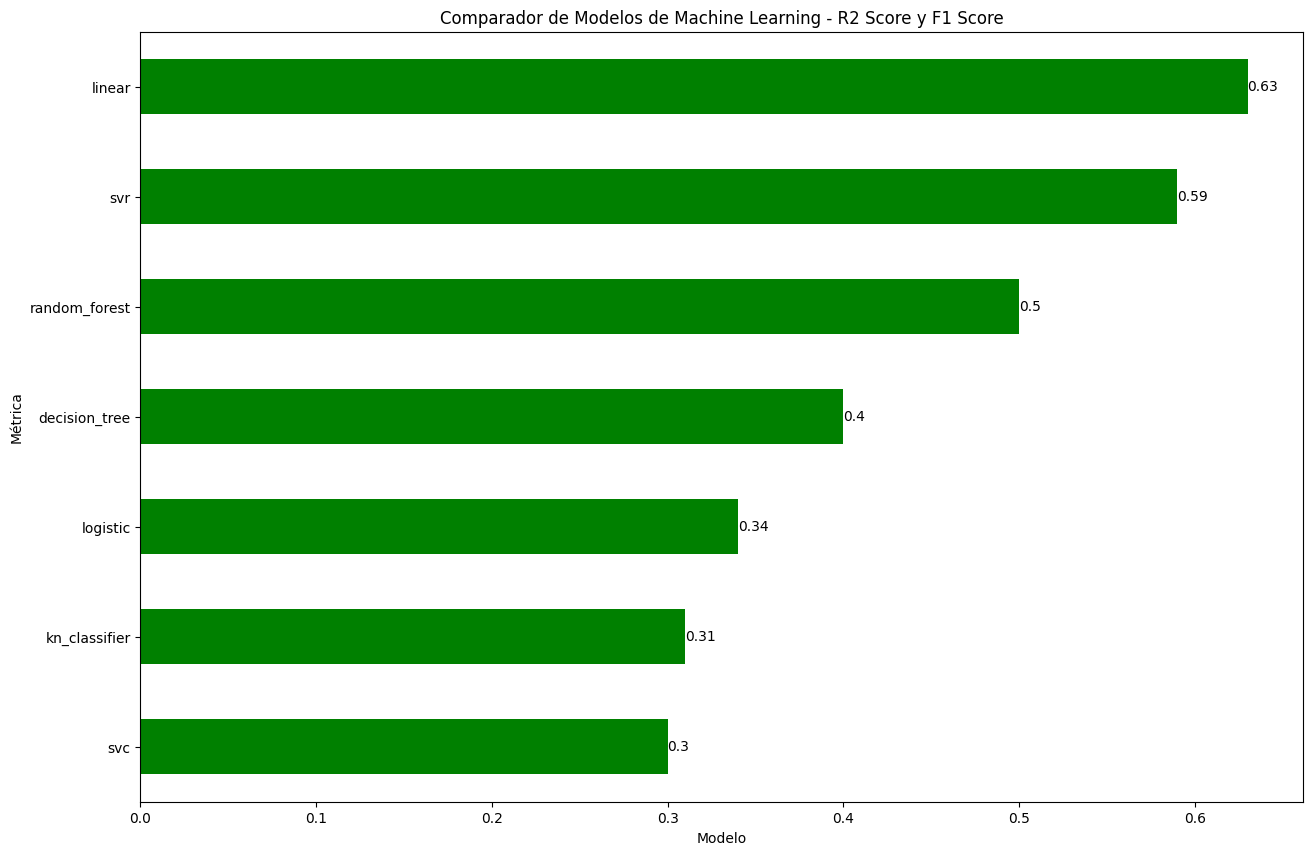

In [64]:
# creamos un DataFrame de pandas con los resultados de la comparación
data = [
    ['svc', svc_r2_score],
    ['kn_classifier', kn_classifier_r2_score],   
    ['logistic', logistic_regression_r2_score],
    ['decision_tree', decision_tree_classifier_r2_score],
    ['random_forest', random_forest_r2_score],
    ['svr', svr_r2_score],
    ['linear', lineal_regression_r2_score]
]

df_models_report = pd.DataFrame(data=data, columns=["model", "metric"])

# representamos los resultados en un gráfico de barras
ax = df_models_report.plot.barh(
    x="model",
    y="metric",
    title="Comparador de Modelos de Machine Learning - R2 Score y F1 Score",
    legend=False,
    xlabel="Modelo",
    ylabel="Métrica",
    color="green",
    figsize=(15,10)
)

# annotate bars
ax.bar_label(ax.containers[0])

_ = ax

##### <center> Grafico - RSME (Error cuadrático medio) de los algoritmos de regresión

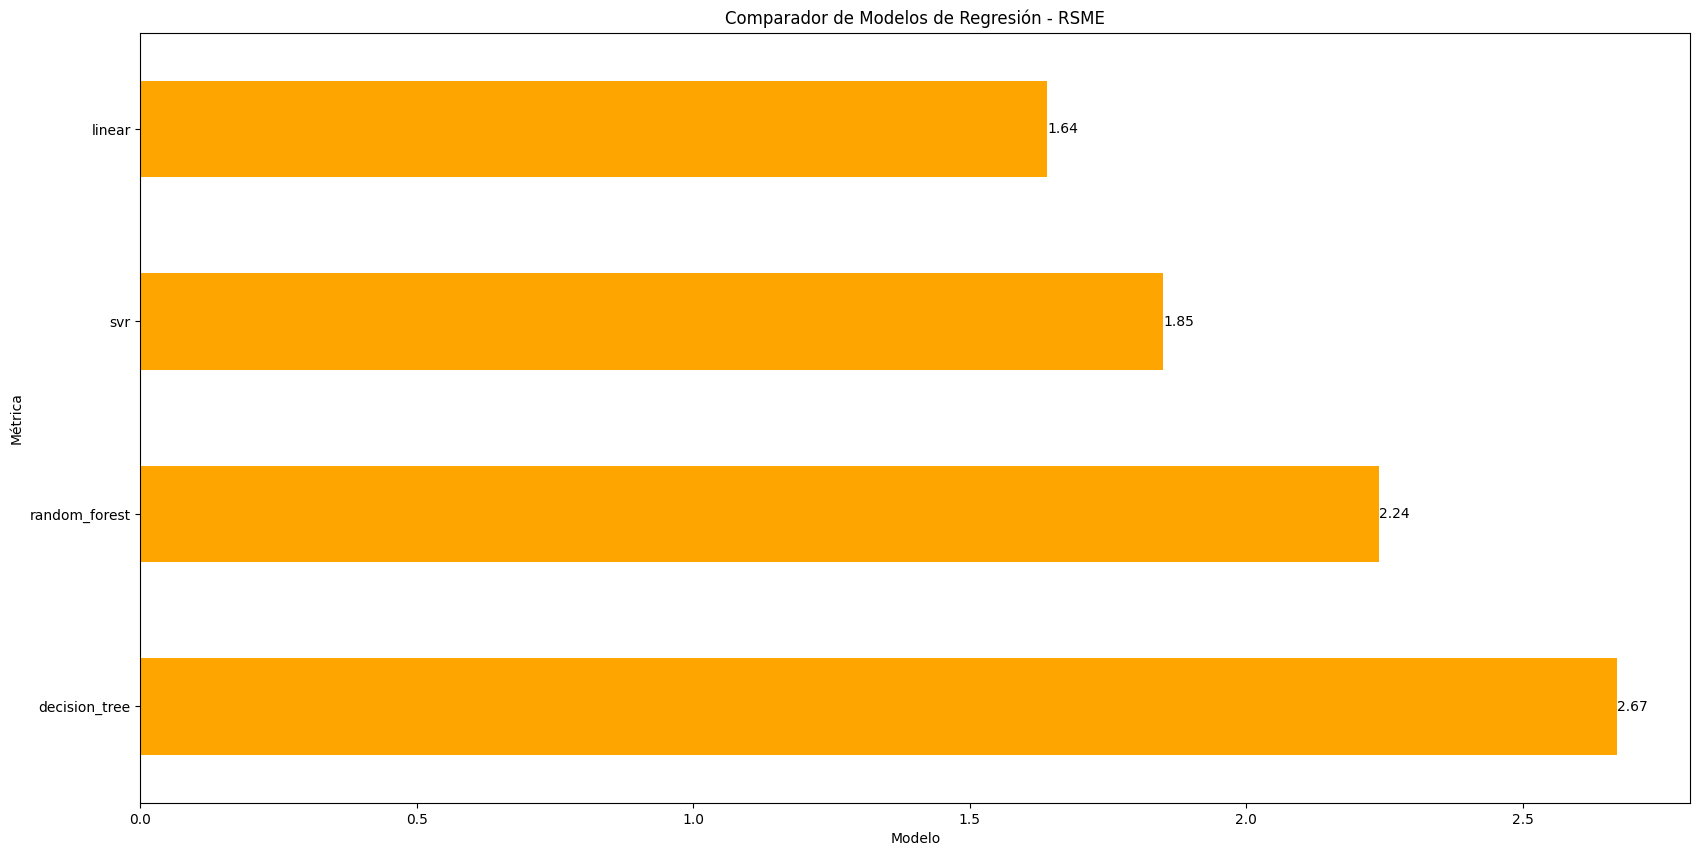

In [65]:
# creamos un DataFrame de pandas con los resultados de la comparación
data_2 = [
    ['decision_tree', decision_tree_classifier_rsme],
    ['random_forest', random_forest_rsme],
    ['svr', svr_rsme],
    ['linear', lineal_regression_rsme],
]

df_models_report = pd.DataFrame(data=data_2, columns=["model", "metric"])

# representamos los resultados en un gráfico de barras
ax = df_models_report.plot.barh(
    x="model",
    y="metric",
    title="Comparador de Modelos de Regresión - RSME",
    legend=False,
    xlabel="Modelo",
    ylabel="Métrica",
    color="orange",
    figsize=(20,10)
)

# annotate bars
ax.bar_label(ax.containers[0])

_ = ax

### <center> Fase de Evaluación

#### <center> Evaluación de Resultados - Aplicación del Modelo a los datos de 2022_3

##### <center> Extraccion de Datos

In [66]:
# Ruta del archivo de configuración
CONFIG_PATH_2023 = "resources/config/extraction_config_2022_3.json"

# Carga la configuración de entrada y salida de la extracción de datos
data_extractor_config = Extractor.json_extractor(CONFIG_PATH_2023).get("data").get("extractor")
input_config = data_extractor_config.get("input")
output_config = data_extractor_config.get("output")

# Realiza la extracción de datos con Pandas para cada fecha en la configuración de entrada
df_pandas_by_date = [
        Extractor(date=date, input_config_dict=config, output_config_dict=output_config).pandas_extractor()
        for date, config in input_config.items()
    ]

# Concatena los dataframes obtenidos con Pandas
df_pandas_concatenated = Concatenator(
        output_config=output_config,
        concatenator_type="pandas"
    ).pandas_concat(df_pandas_by_date, "PANDAS_BAROMETRO_2022_3.csv")

Data extraction complete from JSON file resources/config/extraction_config_2022_3.json
Data Extractor - 2022_3
2022_3_PANDAS_EXTRACTED


##### <center> Limpieza de Datos

In [67]:
INPUT_PATH_PANDAS = "resources/data/extractor/output/concatenated/PANDAS_BAROMETRO_2022_3.csv"
OUTPUT_SEP = ";"
df_extractor_2022_3 = pd.read_csv(INPUT_PATH_PANDAS, sep=OUTPUT_SEP)
df_extractor_2022_3.shape

(2512, 61)

In [68]:
df_process_nan_2022_3 = replace_null_by_value(df_extractor_2022_3, 0)
df_process_dtype_2022_3 = apply_dtype(df_process_nan_2022_3, extractor_dtype)
df_process_split_fecha_ola_2022_3 = split_fecha_ola(df_process_dtype_2022_3)
df_replace_asis_2022_3 = replace_asis(df_process_split_fecha_ola_2022_3)
df_replace_part_elec_2022_3 = replace_part_elec(df_replace_asis_2022_3)
df_norm_part_poli_2022_3 = norm_part_poli(df_replace_part_elec_2022_3)
df_outliers_2022_3 = outliers(df_norm_part_poli_2022_3)
df_clean_2022_3 = df_outliers_2022_3
df_clean_2022_3["FECHA"] = df_clean_2022_3["FECHA"].astype("int32")
df_clean_2022_3.shape

(2512, 61)

##### <center> Seleccion de Variables

In [69]:
# seleccionamos las 30 primeras variables independientes
df_clean_2022_3_ind = df_clean_2022_3[ind_var]
# variable independiente ESCSATI
df_clean_2022_3_dep = df_clean_2022_3[dep_var]

##### <center> Aplicación del Modelo Escogido

In [70]:
# LinearRegression
from sklearn.linear_model import LinearRegression

# Obtención de estimaciones
df_clean_2022_3_pred = model_linear_regression.predict(df_clean_2022_3_ind)

#### <center> Valoración de los resultados

##### <center> Resultados de la respuesta del modelo escogido

In [71]:
# Obtención de los parametros de ajuste
lineal_regression_r2_score = round(r2_score(df_clean_2022_3_dep, df_clean_2022_3_pred), 2)
lineal_regression_rsme = round(mean_squared_error(df_clean_2022_3_dep, df_clean_2022_3_pred), 2)
print('R^2: Linear Regression', lineal_regression_r2_score)
print('RSME: Linear Regression', lineal_regression_rsme)

R^2: Linear Regression 0.55
RSME: Linear Regression 2.08


##### <center> Comparativa con los datos resultados reales

In [72]:
df_result = pd.DataFrame(df_clean_2022_3_dep)
df_result["ESCSATI_PRED"] = df_clean_2022_3_pred
df_result["ESCSATI_PRED"] = df_result["ESCSATI_PRED"].round(2)
df_result.head(10)

,ESCSATI,ESCSATI_PRED
0,7,5.80
1,9,6.42
2,8,4.66
3,10,7.85
4,5,6.70
5,10,7.36
6,7,3.56
7,6,5.88
8,6,5.39
9,7,5.75


### <center> Conclusiones